<a href="https://colab.research.google.com/github/LordRelentless/Order-Reconstruction-Data-Analysis-Challenge-Nth-Mathematics/blob/main/Innocentive_Scrambled_Data_Sim_Nth_Mathematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Median Threshold Weighting: 	The degradation index distribution is very coarse: almost all files share the same baseline value (0.0112), while a handful jump to 0.0270. This binary split is why your ranks are essentially “1–42” in one block and “43–53” in another.
• 	That means the ordering within each block is effectively arbitrary (driven by tie‑breaking in the rank function). On the leaderboard, this will likely give you a valid but low‑accuracy score, because the subtle progression of degradation isn’t being captured.

In [ ]:
import os, glob, time
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Parameters
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,
    "sk_band_hz": (1000, 20000),
    "psd_nperseg": 4096,
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features.csv"
OUT_SUBMISSION = "/content/submission.csv"

# --------------------------
# Loader tuned for challenge CSVs
# --------------------------
def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:,0].astype(float).to_numpy()
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:,1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    zct = np.array([])
    for c in df.columns:
        if "zct" in c.lower() or "tach" in c.lower():
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tachometer
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0/dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach)==0 else np.nanmean(gear_ratio*f_tach)

# --------------------------
# Features
# --------------------------
def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

def tracked_centers(mean_f, factors):
    return {k: factors[k]*mean_f for k in factors} if np.isfinite(mean_f) else {}

def band_energy(f, Pxx, center, pct):
    bw = center*pct
    mask = (f>=center-bw)&(f<=center+bw)
    return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c*pct
        mask &= ~((f>=c-bw)&(f<=c+bw))
    return np.median(Pxx[mask]) if np.any(mask) else np.median(Pxx)

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f>=band[0])&(f<=band[1])
    p = Pxx[mask]
    if len(p)==0: return {"sk_val":0.0,"sk_int":0.0}
    m = np.mean(p)
    if m<=0: return {"sk_val":0.0,"sk_int":0.0}
    return {
        "sk_val": ((p-m)**4).mean()/(m**4+1e-12),
        "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
    }

def extract_file_features(path, params):
    fs=params["fs"]
    t,x,zct=load_file(path,fs)
    mean_f=mean_turbine_freq(zct,params["gear_ratio"])
    centers=tracked_centers(mean_f,params["bearing_factors"])
    f,Pxx=compute_psd(x,fs,params["psd_nperseg"])
    nf=noise_floor(f,Pxx,centers)
    feats={"mean_f_turb":mean_f,"rms":np.sqrt(np.mean(x**2))}
    feats.update(spectral_kurtosis_proxy(x,fs,params["sk_band_hz"],params["psd_nperseg"]))
    for k,c in centers.items():
        e=band_energy(f,Pxx,c,params["bandwidth_pct"])
        feats[f"{k}_energy"]=e
        feats[f"{k}_snr"]=e/(nf+1e-12)
    return feats

# --------------------------
# Nth-style indexing
# --------------------------
def nth_indexing(df):
    N=len(df)
    excitation=np.ones(N)/N
    oscillations=np.zeros(N)
    switch_point=int(np.sqrt(N))
    flip_mask=(df["rms"]>df["rms"].median())|(df["sk_val"]>df["sk_val"].median())
    for _ in range(switch_point):
        excitation*=np.where(flip_mask,-1,1)
        excitation=2*np.mean(excitation)-excitation
        oscillations+=np.abs(excitation)
    symbolic_map=oscillations/switch_point
    return symbolic_map

# --------------------------
# Driver
# --------------------------
def process_dataset(data_dir, params):
    files=[os.path.join(data_dir,f"file_{i:02d}.csv") for i in range(1,54)]
    rows=[]
    for fpath in files:
        feats=extract_file_features(fpath,params)
        rows.append({"file":os.path.basename(fpath),**feats})
    df=pd.DataFrame(rows)

    # Compute degradation index
    degradation_index=nth_indexing(df)
    df["degradation_index"]=degradation_index

    # Sort into chronological order
    order_idx=np.argsort(degradation_index)
    ranks=np.empty(len(df),dtype=int)
    for pos,i in enumerate(order_idx,start=1):
        ranks[i]=pos
    df["predicted_rank"]=ranks

    # Save spreadsheet
    df.to_csv(OUT_SHEET,index=False)

    # Build submission.csv
    N=len(df)
    pred=np.zeros(N,dtype=int)
    for i,row in df.iterrows():
        file_num=int(row["file"].split("_")[1].split(".")[0])
        pred[file_num-1]=row["predicted_rank"]
    pd.DataFrame({"prediction":pred}).to_csv(OUT_SUBMISSION,index=False)

    print("Processed 53 files. Ordered chronologically and outputs saved.")

# --------------------------
# Run
# --------------------------
process_dataset(DATA_DIR, PARAMS)

/tmp/ipython-input-2919726044.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2919726044.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2919726044.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2919726044.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2919726044.py:83: DeprecationWarning: `trapz` is deprecated

Processed 53 files. Ordered chronologically and outputs saved.


/tmp/ipython-input-2919726044.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2919726044.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0


Refinement: Quantile Weighting;
The degradation index distribution is now multi‑level rather than binary, which is a big improvement. You’ve got clusters around ~0.26, 0.31, 0.44, 0.55, 0.77, 0.81.
• 	That said, there are still plateaus: many files share the same index (e.g. 0.5557 or 0.8188). Within those plateaus, the rank assignment is essentially arbitrary (driven by tie‑breaking). This could still limit leaderboard accuracy.
• 	To further refine:
• 	Increase the weight diversity (e.g. give more continuous influence to RMS growth and kurtosis magnitude).
• 	Use a weighted sum of normalized features directly as part of the degradation index, not just as thresholds for flip masks.
• 	Consider smoothing across ranks (e.g. isotonic regression) to enforce monotonicity and reduce ties.

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Parameters
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,
    "sk_band_hz": (1000, 20000),
    "psd_nperseg": 4096,
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features_refined.csv"
OUT_SUBMISSION = "/content/submission.csv"

NTH_CONFIG = {
    "q_primary": 0.75,       # quantile for primary flip mask
    "q_secondary": 0.60,     # quantile for secondary weighting emphasis
    "phase2_gain": 0.6,      # gain for Phase 2 injected weights
    "mix_primary_bias": 0.7, # mix between Phase1 symbolic_map and Phase2 bias
}

# --------------------------
# Loader tuned for challenge CSVs
# --------------------------
def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:, 0].astype(float).to_numpy()
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:, 1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    zct = np.array([])
    for c in df.columns:
        if "zct" in c.lower() or "tach" in c.lower():
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tachometer processing
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0 / dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach) == 0 else np.nanmean(gear_ratio * f_tach)

# --------------------------
# Features
# --------------------------
def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

def tracked_centers(mean_f, factors):
    return {k: factors[k] * mean_f for k in factors} if np.isfinite(mean_f) else {}

def band_energy(f, Pxx, center, pct):
    bw = center * pct
    mask = (f >= center - bw) & (f <= center + bw)
    return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c * pct
        mask &= ~((f >= c - bw) & (f <= c + bw))
    return np.median(Pxx[mask]) if np.any(mask) else np.median(Pxx)

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f >= band[0]) & (f <= band[1])
    p = Pxx[mask]
    if len(p) == 0: return {"sk_val": 0.0, "sk_int": 0.0}
    m = np.mean(p)
    if m <= 0: return {"sk_val": 0.0, "sk_int": 0.0}
    return {
        "sk_val": ((p - m) ** 4).mean() / (m ** 4 + 1e-12),
        "sk_int": np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12)
    }

def extract_file_features(path, params):
    fs = params["fs"]
    t, x, zct = load_file(path, fs)
    mean_f = mean_turbine_freq(zct, params["gear_ratio"])
    centers = tracked_centers(mean_f, params["bearing_factors"])
    f, Pxx = compute_psd(x, fs, params["psd_nperseg"])
    nf = noise_floor(f, Pxx, centers)
    feats = {"mean_f_turb": mean_f, "rms": float(np.sqrt(np.mean(x**2)))}
    feats.update(spectral_kurtosis_proxy(x, fs, params["sk_band_hz"], params["psd_nperseg"]))
    for k, c in centers.items():
        e = band_energy(f, Pxx, c, params["bandwidth_pct"])
        feats[f"{k}_energy"] = e
        feats[f"{k}_snr"] = e / (nf + 1e-12)
    # Envelope crest (global proxy)
    env = np.abs(hilbert(x))
    feats["crest_factor"] = float(np.max(env) / (np.mean(env) + 1e-12))
    return feats

# --------------------------
# Normalization helpers
# --------------------------
def rank_normalize(series):
    r = series.rank(method="average").to_numpy()
    n = len(series)
    return (r - 1) / (max(n - 1, 1))

def safe_fill(df, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

# --------------------------
# Nth Mathematics refined indexing
# --------------------------
def nth_refined_degradation_index(df, cfg):
    N = len(df)
    # Primary features: drive flip mask
    primary_cols = [c for c in ["rms", "sk_val", "sk_int", "inner_snr", "outer_snr"] if c in df.columns]
    secondary_cols = [c for c in ["cage_snr", "ball_snr", "crest_factor"] if c in df.columns]

    # Normalize features (rank-based for robustness)
    norm = {}
    for c in primary_cols + secondary_cols:
        norm[c] = rank_normalize(df[c].fillna(df[c].median()))

    # Build primary composite (weighted)
    w_primary = {
        "rms": 0.30,
        "sk_val": 0.25,
        "sk_int": 0.15,
        "inner_snr": 0.20,
        "outer_snr": 0.10
    }
    primary_score = sum(w_primary.get(c, 0) * norm[c] for c in primary_cols)

    # Quantile-based flip mask (select later/more degraded)
    q = cfg["q_primary"]
    thr = np.quantile(primary_score, q)
    flip_mask = primary_score >= thr

    # Nth Phase 1: amplification over selected set
    excitation = np.ones(N) / N
    oscillations = np.zeros(N)
    switch_point = int(np.sqrt(N))
    for _ in range(switch_point):
        excitation *= np.where(flip_mask, -1, 1)
        excitation = 2 * np.mean(excitation) - excitation
        oscillations += np.abs(excitation)
    symbolic_map = oscillations / switch_point
    symbolic_map = rank_normalize(pd.Series(symbolic_map))

    # Secondary trend weights
    w_secondary = {
        "cage_snr": 0.40,
        "ball_snr": 0.40,
        "crest_factor": 0.20
    }
    secondary_score = sum(w_secondary.get(c, 0) * norm[c] for c in secondary_cols)
    q2 = cfg["q_secondary"]
    # Emphasize the upper trend by clipping below quantile
    sec_emph = np.clip(secondary_score - np.quantile(secondary_score, q2), 0, 1)

    # Nth Phase 2: inject weights
    for _ in range(switch_point):
        excitation += cfg["phase2_gain"] * sec_emph
        excitation = 2 * np.mean(excitation) - excitation

    # Phase-2 bias (normalize)
    bias = (excitation - np.min(excitation)) / (np.max(excitation) - np.min(excitation) + 1e-12)

    # Final degradation index (smooth mix)
    mix = cfg["mix_primary_bias"]
    degradation_index = mix * symbolic_map + (1 - mix) * bias
    return degradation_index

# --------------------------
# Ordering and submission
# --------------------------
def to_submission_positions(order_idx, N):
    positions = np.empty(N, dtype=int)
    for pos, i in enumerate(order_idx, start=1):
        positions[i] = pos
    return positions

def process_dataset(data_dir, params, cfg):
    files = [os.path.join(data_dir, f"file_{i:02d}.csv") for i in range(1, 54)]
    rows = []
    for fpath in files:
        feats = extract_file_features(fpath, params)
        rows.append({"file": os.path.basename(fpath), **feats})
    df = pd.DataFrame(rows)

    # Ensure consistent columns
    ordered_cols = ["file", "mean_f_turb", "rms", "crest_factor", "sk_val", "sk_int",
                    "cage_energy", "cage_snr", "ball_energy", "ball_snr",
                    "inner_energy", "inner_snr", "outer_energy", "outer_snr"]
    df = safe_fill(df, ordered_cols)

    # Compute refined degradation index
    deg_index = nth_refined_degradation_index(df, cfg)
    df["degradation_index"] = deg_index

    # Sort into chronological order
    order_idx = np.argsort(deg_index)  # earliest → latest
    ranks = to_submission_positions(order_idx, len(df))
    df["predicted_rank"] = ranks

    # Save spreadsheet
    df.to_csv(OUT_SHEET, index=False)

    # Build submission.csv (row i = predicted position of file_i.csv)
    N = len(df)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file"].split("_")[1].split(".")[0])
        pred[file_num - 1] = int(row["predicted_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Processed {N} files. Saved {OUT_SHEET} and {OUT_SUBMISSION}.")

# --------------------------
# Run
# --------------------------
process_dataset(DATA_DIR, PARAMS, NTH_CONFIG)

/tmp/ipython-input-1899487554.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12)
/tmp/ipython-input-1899487554.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-1899487554.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12)
/tmp/ipython-input-1899487554.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-1899487554.py:90: DeprecationWarning:

Processed 53 files. Saved /content/bearing_features_refined.csv and /content/submission.csv.


Refinement 2:Tie Reduction through Symbolic Weighting of sum factors ~RMS + kurtosis + band SNRs + plateau frequencies aggregate comparison.

The symbolic weighted aggregate has eliminated ties: every file now has a distinct degradation index.The ordering is smoother and more discriminative than your earlier binary or plateaued versions.There are still clusters (e.g. many files in the 0.70–0.75 range), but because the aggregate is continuous, they still sort uniquely. This is now a proper monotonic trajectory suitable for leaderboard scoring.

In [ ]:
import os, glob
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Parameters
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,
    "sk_band_hz": (1000, 20000),
    "psd_nperseg": 4096,
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features_symbolic.csv"
OUT_SUBMISSION = "/content/submission.csv"

# --------------------------
# Loader
# --------------------------
def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:,0].astype(float).to_numpy()
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:,1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    zct = np.array([])
    for c in df.columns:
        if "zct" in c.lower() or "tach" in c.lower():
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tachometer
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0/dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach)==0 else np.nanmean(gear_ratio*f_tach)

# --------------------------
# Features
# --------------------------
def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

def tracked_centers(mean_f, factors):
    return {k: factors[k]*mean_f for k in factors} if np.isfinite(mean_f) else {}

def band_energy(f, Pxx, center, pct):
    bw = center*pct
    mask = (f>=center-bw)&(f<=center+bw)
    return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c*pct
        mask &= ~((f>=c-bw)&(f<=c+bw))
    return np.median(Pxx[mask]) if np.any(mask) else np.median(Pxx)

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f>=band[0])&(f<=band[1])
    p = Pxx[mask]
    if len(p)==0: return {"sk_val":0.0,"sk_int":0.0}
    m = np.mean(p)
    if m<=0: return {"sk_val":0.0,"sk_int":0.0}
    return {
        "sk_val": ((p-m)**4).mean()/(m**4+1e-12),
        "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
    }

def extract_file_features(path, params):
    fs=params["fs"]
    t,x,zct=load_file(path,fs)
    mean_f=mean_turbine_freq(zct,params["gear_ratio"])
    centers=tracked_centers(mean_f,params["bearing_factors"])
    f,Pxx=compute_psd(x,fs,params["psd_nperseg"])
    nf=noise_floor(f,Pxx,centers)
    feats={"mean_f_turb":mean_f,"rms":np.sqrt(np.mean(x**2))}
    feats.update(spectral_kurtosis_proxy(x,fs,params["sk_band_hz"],params["psd_nperseg"]))
    for k,c in centers.items():
        e=band_energy(f,Pxx,c,params["bandwidth_pct"])
        feats[f"{k}_energy"]=e
        feats[f"{k}_snr"]=e/(nf+1e-12)
    env=np.abs(hilbert(x))
    feats["crest_factor"]=np.max(env)/(np.mean(env)+1e-12)
    return feats

# --------------------------
# Normalization
# --------------------------
def rank_normalize(series):
    r = series.rank(method="average").to_numpy()
    n = len(series)
    return (r - 1) / (max(n - 1, 1))

# --------------------------
# Nth Mathematics symbolic aggregate
# --------------------------
def nth_symbolic_index(df):
    N=len(df)
    # Normalize features
    rms_n = rank_normalize(df["rms"])
    sk_n = rank_normalize(df["sk_val"] + df["sk_int"])
    snr_n = rank_normalize(df["inner_snr"] + df["outer_snr"])
    plateau_n = rank_normalize(df["cage_snr"] + df["ball_snr"])
    # Weighted aggregate
    wear_level = 0.3*rms_n + 0.3*sk_n + 0.3*snr_n + 0.1*plateau_n
    # Nth amplification loop
    excitation = np.ones(N)/N
    oscillations = np.zeros(N)
    switch_point = int(np.sqrt(N))
    flip_mask = wear_level > np.quantile(wear_level,0.75)
    for _ in range(switch_point):
        excitation *= np.where(flip_mask,-1,1)
        excitation = 2*np.mean(excitation)-excitation
        oscillations += np.abs(excitation)
    symbolic_map = oscillations/switch_point
    symbolic_map = rank_normalize(pd.Series(symbolic_map))
    # Blend with wear_level to eliminate ties
    degradation_index = 0.7*wear_level + 0.3*symbolic_map
    return degradation_index

# --------------------------
# Ordering and submission
# --------------------------
def to_submission_positions(order_idx, N):
    positions = np.empty(N, dtype=int)
    for pos, i in enumerate(order_idx, start=1):
        positions[i] = pos
    return positions

def process_dataset(data_dir, params):
    files=[os.path.join(data_dir,f"file_{i:02d}.csv") for i in range(1,54)]
    rows=[]
    for fpath in files:
        feats=extract_file_features(fpath,params)
        rows.append({"file":os.path.basename(fpath),**feats})
    df=pd.DataFrame(rows)
    # Compute symbolic degradation index
    deg_index=nth_symbolic_index(df)
    df["degradation_index"]=deg_index
    # Sort into chronological order
    order_idx=np.argsort(deg_index)
    ranks=to_submission_positions(order_idx,len(df))
    df["predicted_rank"]=ranks
    # Save spreadsheet
    df.to_csv(OUT_SHEET,index=False)
    # Build submission.csv
    N=len(df)
    pred=np.zeros(N,dtype=int)
    for i,row in df.iterrows():
        file_num=int(row["file"].split("_")[1].split(".")[0])
        pred[file_num-1]=int(row["predicted_rank"])
    pd.DataFrame({"prediction":pred}).to_csv(OUT_SUBMISSION,index=False)
    print("Processed 53 files. Outputs saved.")

# --------------------------
# Run
# --------------------------
process_dataset(DATA_DIR, PARAMS)

/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2197508289.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2197508289.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated

Processed 53 files. Outputs saved.


/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2197508289.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-2197508289.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[mask], f[mask]) if np.any(mask) else 0.0
/tmp/ipython-input-2197508289.py:83: DeprecationWarning: `trapz` is deprecated

Refinement 3: Contiuous weighting through multiple abstraction.

The ordering is now smoother and more discriminative than earlier iterations. The degradation index is continuous and tie‑free.
• 	The ranks are distributed across the full 1–53 range, with no plateaus.
• 	The isotonic regression smoothing appears to have enforced a monotonic trajectory, which is good for leaderboard scoring.
• 	The dynamic weighting and feature expansion (entropy, sidebands, crest factor) are reflected in the spread of degradation indices.


In [ ]:
import os, glob
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Configuration
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,          # ±1% for band energy
    "sideband_pct": 0.005,          # ±0.5% windows for sidebands
    "psd_nperseg": 4096,
    "sk_band_hz": (1000, 20000),
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features_dynamic.csv"
OUT_SUBMISSION = "/content/submission.csv"

# --------------------------
# Basic I/O
# --------------------------
def list_files():
    return [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:, 0].astype(float).to_numpy()
    # optional time
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:, 1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    # optional zct/tach
    zct = np.array([])
    for c in df.columns:
        if "zct" in c.lower() or "tach" in c.lower():
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tach and PSD
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0 / dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach) == 0 else np.nanmean(gear_ratio * f_tach)

def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

# --------------------------
# Feature helpers
# --------------------------
def tracked_centers(mean_f_turb, factors):
    return {k: factors[k] * mean_f_turb for k in factors} if np.isfinite(mean_f_turb) else {}

def band_energy(f, Pxx, center, pct):
    if not np.isfinite(center) or center <= 0: return 0.0
    bw = center * pct
    mask = (f >= center - bw) & (f <= center + bw)
    return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c * pct
        mask &= ~((f >= c - bw) & (f <= c + bw))
    return float(np.median(Pxx[mask])) if np.any(mask) else float(np.median(Pxx))

def sideband_energy(f, Pxx, center, spacing, pct):
    # Sum energy in windows around center±spacing
    e = 0.0
    for sgn in (-1, +1):
        sb = center + sgn * spacing
        bw = sb * pct
        mask = (f >= sb - bw) & (f <= sb + bw)
        if np.any(mask):
            e += float(np.trapz(Pxx[mask], f[mask]))
    return e

def spectral_entropy(Pxx):
    p = Pxx.copy()
    p = p / (np.sum(p) + 1e-12)
    p = np.clip(p, 1e-12, 1.0)
    H = -np.sum(p * np.log(p))
    # Normalize by log(N) for [0,1]
    return float(H / (np.log(len(p) + 1e-12)))

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f >= band[0]) & (f <= band[1])
    p = Pxx[mask]
    if len(p) == 0: return {"sk_val": 0.0, "sk_int": 0.0}
    m = np.mean(p)
    if m <= 0: return {"sk_val": 0.0, "sk_int": 0.0}
    sk_val = float(((p - m)**4).mean() / (m**4 + 1e-12))
    sk_int = float(np.trapz((p - m)**4, f[mask]) / (m**4 + 1e-12))
    return {"sk_val": sk_val, "sk_int": sk_int}

# --------------------------
# Per-file features (expanded)
# --------------------------
def extract_file_features(path, params):
    fs = params["fs"]
    t, x, zct = load_file(path, fs)
    mean_f = mean_turbine_freq(zct, params["gear_ratio"])
    centers = tracked_centers(mean_f, params["bearing_factors"])

    f, Pxx = compute_psd(x, fs, params["psd_nperseg"])
    nf = noise_floor(f, Pxx, centers, pct=2 * params["bandwidth_pct"])

    feats = {
        "file": os.path.basename(path),
        "mean_f_turb": mean_f,
        "rms": float(np.sqrt(np.mean(x**2)))
    }

    # Envelope crest factor
    env = np.abs(hilbert(x))
    feats["crest_factor"] = float(np.max(env) / (np.mean(env) + 1e-12))

    # Spectral entropy (broadband)
    feats["spec_entropy"] = spectral_entropy(Pxx)

    # Spectral kurtosis proxies
    feats.update(spectral_kurtosis_proxy(x, fs, params["sk_band_hz"], params["psd_nperseg"]))

    # Speed-tracked bands: energies, SNRs, sideband ratios
    for k, c in centers.items():
        e = band_energy(f, Pxx, c, params["bandwidth_pct"])
        snr = e / (nf + 1e-12)
        feats[f"{k}_energy"] = e
        feats[f"{k}_snr"] = snr

    # Sideband ratios for inner/outer (spacing ~ cage frequency if available)
    if "cage" in centers:
        spacing = centers["cage"]
        for k in ("inner", "outer"):
            if k in centers:
                c = centers[k]
                e_center = band_energy(f, Pxx, c, params["bandwidth_pct"])
                e_side = sideband_energy(f, Pxx, c, spacing, params["sideband_pct"])
                feats[f"{k}_sb_ratio"] = float(e_side / (e_center + 1e-12))
    else:
        feats["inner_sb_ratio"] = np.nan
        feats["outer_sb_ratio"] = np.nan

    return feats

# --------------------------
# Normalization and utilities
# --------------------------
def rank_normalize(a):
    s = pd.Series(a)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn: return np.zeros_like(a)
    return (a - mn) / (mx - mn)

def safe_col(df, name, fill=np.nan):
    if name not in df.columns:
        df[name] = fill

# --------------------------
# Dynamic weighting (unsupervised heuristic)
# --------------------------
def dynamic_weights(df, feature_cols):
    # Unsupervised heuristic: give higher weights to features with
    # - higher variance (spread)
    # - lower redundancy (correlation with others)
    X = np.column_stack([rank_normalize(df[c].fillna(df[c].median())) for c in feature_cols])
    var = np.var(X, axis=0) + 1e-9
    corr = np.corrcoef(X.T)
    # Redundancy penalty = mean absolute correlation with others
    red = np.mean(np.abs(corr - np.eye(len(feature_cols))), axis=1)
    score = var / (red + 1e-9)
    w = score / (np.sum(score) + 1e-12)
    return {c: float(w[i]) for i, c in enumerate(feature_cols)}

# --------------------------
# Nth Mathematics amplification
# --------------------------
def nth_amplify(base_signal):
    N = len(base_signal)
    switch_point = max(1, int(np.sqrt(N)))
    excitation = np.ones(N) / N
    oscillations = np.zeros(N)
    thr = np.quantile(base_signal, 0.75)
    flip_mask = base_signal >= thr
    for _ in range(switch_point):
        excitation *= np.where(flip_mask, -1.0, 1.0)
        excitation = 2.0 * np.mean(excitation) - excitation
        oscillations += np.abs(excitation)
    symbolic_map = oscillations / float(switch_point)
    return rank_normalize(symbolic_map)

# --------------------------
# Isotonic regression (PAVA)
# --------------------------
def isotonic_pava(y):
    # Monotone non-decreasing sequence
    y = np.asarray(y, dtype=float)
    n = len(y)
    w = np.ones(n, dtype=float)
    x = y.copy()
    i = 0
    while i < n - 1:
        if x[i] <= x[i + 1]:
            i += 1
            continue
        # Pool adjacent violators
        j = i
        while j >= 0 and x[j] > x[j + 1]:
            tot_w = w[j] + w[j + 1]
            avg = (w[j] * x[j] + w[j + 1] * x[j + 1]) / tot_w
            x[j] = avg
            x[j + 1] = avg
            w[j] = tot_w
            w[j + 1] = tot_w
            j -= 1
        i += 1
    # Final pass to ensure non-decreasing
    for i in range(n - 1):
        if x[i] > x[i + 1]:
            x[i + 1] = x[i]
    return x

# --------------------------
# Build aggregate, tune weights, amplify, smooth
# --------------------------
def compute_degradation_index(df):
    # Ensure expected columns exist
    needed = [
        "rms", "sk_val", "sk_int", "inner_snr", "outer_snr",
        "cage_snr", "ball_snr", "crest_factor", "spec_entropy",
        "inner_sb_ratio", "outer_sb_ratio"
    ]
    for c in needed:
        safe_col(df, c)

    # Normalize features robustly (rank-based)
    norm = {}
    for c in needed:
        norm[c] = rank_normalize(df[c].fillna(df[c].median()))

    # Primary set (core wear signals)
    primary_cols = ["rms", "sk_val", "sk_int", "inner_snr", "outer_snr", "spec_entropy"]
    # Secondary set (modulation and early indicators)
    secondary_cols = ["cage_snr", "ball_snr", "crest_factor", "inner_sb_ratio", "outer_sb_ratio"]

    # Dynamic weights for both sets
    w_primary = dynamic_weights(df, primary_cols)
    w_secondary = dynamic_weights(df, secondary_cols)

    primary_score = sum(w_primary[c] * norm[c] for c in primary_cols)
    secondary_score = sum(w_secondary[c] * norm[c] for c in secondary_cols)

    # Symbolic weighted aggregate
    wear_level = 0.7 * primary_score + 0.3 * secondary_score

    # Nth amplification overlay
    nth_map = nth_amplify(wear_level)

    # Blend and smooth (isotonic regression to enforce monotone trajectory)
    raw_index = 0.6 * wear_level + 0.4 * nth_map
    iso_index = isotonic_pava(raw_index)

    # Min-max normalize final index for readability
    final_index = minmax_normalize(iso_index)
    return final_index, w_primary, w_secondary

# --------------------------
# Ordering and submission
# --------------------------
def to_submission_positions(order_idx, N):
    positions = np.empty(N, dtype=int)
    for pos, i in enumerate(order_idx, start=1):
        positions[i] = pos
    return positions

def process_dataset():
    files = list_files()
    rows = []
    for path in files:
        feats = extract_file_features(path, PARAMS)
        rows.append(feats)
    df = pd.DataFrame(rows)

    # Compute final degradation index
    deg_index, w_primary, w_secondary = compute_degradation_index(df)
    df["degradation_index"] = deg_index

    # Order chronologically (ascending: earliest -> latest)
    order_idx = np.argsort(deg_index)
    ranks = to_submission_positions(order_idx, len(df))
    df["predicted_rank"] = ranks

    # Save spreadsheet
    # Include dynamic weights summary for transparency
    for c, w in w_primary.items():
        df[f"w_primary_{c}"] = w
    for c, w in w_secondary.items():
        df[f"w_secondary_{c}"] = w
    df.to_csv(OUT_SHEET, index=False)

    # Build submission.csv (row i = predicted position of file_i.csv)
    N = len(df)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file"].split("_")[1].split(".")[0])
        pred[file_num - 1] = int(row["predicted_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Processed {N} files.")
    print(f"Saved: {OUT_SHEET} and {OUT_SUBMISSION}")
    print("Dynamic weights (primary):", w_primary)
    print("Dynamic weights (secondary):", w_secondary)

# --------------------------
# Run
# --------------------------
process_dataset()

/tmp/ipython-input-3033863246.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m)**4, f[mask]) / (m**4 + 1e-12))
/tmp/ipython-input-3033863246.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-3033863246.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  e += float(np.trapz(Pxx[mask], f[mask]))
/tmp/ipython-input-3033863246.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m)**4, f[mask]) / (m**4 + 1e-12))
/tmp/ipython-input-3033863246.py:72: DeprecationWarning: `trapz

Processed 53 files.
Saved: /content/bearing_features_dynamic.csv and /content/submission.csv
Dynamic weights (primary): {'rms': 0.22971552604094145, 'sk_val': 0.112728546571869, 'sk_int': 0.112728546571869, 'inner_snr': 0.1504749787115314, 'outer_snr': 0.22373381593741545, 'spec_entropy': 0.17061858616610548}
Dynamic weights (secondary): {'cage_snr': nan, 'ball_snr': nan, 'crest_factor': nan, 'inner_sb_ratio': nan, 'outer_sb_ratio': nan}


/tmp/ipython-input-3033863246.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m)**4, f[mask]) / (m**4 + 1e-12))
/tmp/ipython-input-3033863246.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-3033863246.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  e += float(np.trapz(Pxx[mask], f[mask]))
/tmp/ipython-input-3033863246.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m)**4, f[mask]) / (m**4 + 1e-12))
/tmp/ipython-input-3033863246.py:72: DeprecationWarning: `trapz

Refinement 4: Weight tuning, Cross-indexing, & Temporal Smoothing

The ordering is valid and tie‑free, but the degradation index values are heavily plateaued. Many files share the same normalized index, which means the ranking is being driven almost entirely by the isotonic/temporal smoothing overlay rather than fine‑grained feature differences.
• 	This can reduce discriminative power on the leaderboard, since subtle distinctions between mid‑life files are being collapsed.
• 	The cross‑terms and weight tuning are present, but their influence may be muted by the strong smoothing.

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Configuration
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,          # ±1% around tracked centers
    "sideband_pct": 0.005,          # ±0.5% windows for sidebands
    "psd_nperseg": 4096,
    "sk_band_hz": (1000, 20000),
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features_weight_tuned.csv"
OUT_SUBMISSION = "/content/Refinement4_submission.csv"

# --------------------------
# IO helpers
# --------------------------
def list_files():
    return [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:, 0].astype(float).to_numpy()
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:, 1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    zct = np.array([])
    for c in df.columns:
        cl = c.lower()
        if "zct" in cl or "tach" in cl:
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tach and PSD
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0 / dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach) == 0 else np.nanmean(gear_ratio * f_tach)

def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

# --------------------------
# Feature helpers
# --------------------------
def tracked_centers(mean_f_turb, factors):
    return {k: factors[k] * mean_f_turb for k in factors} if np.isfinite(mean_f_turb) else {}

def band_energy(f, Pxx, center, pct):
    if not np.isfinite(center) or center <= 0: return 0.0
    bw = center * pct
    mask = (f >= center - bw) & (f <= center + bw)
    return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c * pct
        mask &= ~((f >= c - bw) & (f <= c + bw))
    return float(np.median(Pxx[mask])) if np.any(mask) else float(np.median(Pxx))

def sideband_energy(f, Pxx, center, spacing, pct):
    e = 0.0
    for sgn in (-1, +1):
        sb = center + sgn * spacing
        bw = sb * pct
        mask = (f >= sb - bw) & (f <= sb + bw)
        if np.any(mask):
            e += float(np.trapz(Pxx[mask], f[mask]))
    return e

def spectral_entropy(Pxx):
    p = Pxx.copy()
    p = p / (np.sum(p) + 1e-12)
    p = np.clip(p, 1e-12, 1.0)
    H = -np.sum(p * np.log(p))
    return float(H / (np.log(len(p) + 1e-12)))

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f >= band[0]) & (f <= band[1])
    p = Pxx[mask]
    if len(p) == 0: return {"sk_val": 0.0, "sk_int": 0.0}
    m = np.mean(p)
    if m <= 0: return {"sk_val": 0.0, "sk_int": 0.0}
    sk_val = float(((p - m) ** 4).mean() / (m ** 4 + 1e-12))
    sk_int = float(np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12))
    return {"sk_val": sk_val, "sk_int": sk_int}

# --------------------------
# Per-file features (expanded)
# --------------------------
def extract_file_features(path, params):
    fs = params["fs"]
    t, x, zct = load_file(path, fs)
    mean_f = mean_turbine_freq(zct, params["gear_ratio"])
    centers = tracked_centers(mean_f, params["bearing_factors"])

    f, Pxx = compute_psd(x, fs, params["psd_nperseg"])
    nf = noise_floor(f, Pxx, centers, pct=2 * params["bandwidth_pct"])

    feats = {
        "file": os.path.basename(path),
        "mean_f_turb": mean_f,
        "rms": float(np.sqrt(np.mean(x**2)))
    }

    env = np.abs(hilbert(x))
    feats["crest_factor"] = float(np.max(env) / (np.mean(env) + 1e-12))
    feats["spec_entropy"] = spectral_entropy(Pxx)
    feats.update(spectral_kurtosis_proxy(x, fs, params["sk_band_hz"], params["psd_nperseg"]))

    for k, c in centers.items():
        e = band_energy(f, Pxx, c, params["bandwidth_pct"])
        feats[f"{k}_energy"] = e
        feats[f"{k}_snr"] = e / (nf + 1e-12)

    # Sideband ratios using cage frequency as spacing
    if "cage" in centers:
        spacing = centers["cage"]
        for k in ("inner", "outer"):
            if k in centers:
                c = centers[k]
                e_center = band_energy(f, Pxx, c, params["bandwidth_pct"])
                e_side = sideband_energy(f, Pxx, c, spacing, params["sideband_pct"])
                feats[f"{k}_sb_ratio"] = float(e_side / (e_center + 1e-12))
    else:
        feats["inner_sb_ratio"] = np.nan
        feats["outer_sb_ratio"] = np.nan

    return feats

# --------------------------
# Normalization
# --------------------------
def rank_normalize(a):
    s = pd.Series(a)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn: return np.zeros_like(a)
    return (a - mn) / (mx - mn)

# --------------------------
# Cross-term indexing
# --------------------------
def add_cross_terms(df):
    # Ensure needed columns exist
    for c in ["rms","sk_val","sk_int","inner_snr","outer_snr","spec_entropy"]:
        if c not in df.columns: df[c] = np.nan

    df["rms_sk"] = df["rms"] * (df["sk_val"] + df["sk_int"])
    df["snr_entropy"] = (df["inner_snr"] + df["outer_snr"]) * df["spec_entropy"]
    df["rms_entropy"] = df["rms"] * df["spec_entropy"]
    return df

# --------------------------
# Weight tuning (random search for smooth aggregate)
# --------------------------
def tune_weights(df, feature_cols, n_iter=200, seed=42):
    rng = np.random.default_rng(seed)
    normed = {c: rank_normalize(df[c].fillna(df[c].median())) for c in feature_cols}
    best_w = None
    best_score = np.inf
    for _ in range(n_iter):
        w = rng.random(len(feature_cols))
        w /= (np.sum(w) + 1e-12)
        agg = sum(w[i] * normed[c] for i, c in enumerate(feature_cols))
        # Smoothness criterion: variance of sorted adjacent differences
        diffs = np.diff(np.sort(agg))
        score = np.var(diffs)
        if score < best_score:
            best_score = score
            best_w = w
    return {c: float(best_w[i]) for i, c in enumerate(feature_cols)}

# --------------------------
# Nth Mathematics amplification
# --------------------------
def nth_amplify(base_signal):
    N = len(base_signal)
    switch_point = max(1, int(np.sqrt(N)))
    excitation = np.ones(N) / N
    oscillations = np.zeros(N)
    thr = np.quantile(base_signal, 0.75)
    flip_mask = base_signal >= thr
    for _ in range(switch_point):
        excitation *= np.where(flip_mask, -1.0, 1.0)
        excitation = 2.0 * np.mean(excitation) - excitation
        oscillations += np.abs(excitation)
    symbolic_map = oscillations / float(switch_point)
    return rank_normalize(symbolic_map)

# --------------------------
# Isotonic regression (PAVA) and temporal smoothing
# --------------------------
def isotonic_pava(y):
    y = np.asarray(y, dtype=float)
    n = len(y)
    w = np.ones(n, dtype=float)
    x = y.copy()
    i = 0
    while i < n - 1:
        if x[i] <= x[i + 1]:
            i += 1
            continue
        j = i
        while j >= 0 and x[j] > x[j + 1]:
            tot_w = w[j] + w[j + 1]
            avg = (w[j] * x[j] + w[j + 1] * x[j + 1]) / tot_w
            x[j] = avg
            x[j + 1] = avg
            w[j] = tot_w
            w[j + 1] = tot_w
            j -= 1
        i += 1
    for i in range(n - 1):
        if x[i] > x[i + 1]:
            x[i + 1] = x[i]
    return x

def temporal_smooth(values, window=5):
    if window <= 1: return values
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(values, kernel, mode="same")

# --------------------------
# Build aggregate, tune weights, amplify, smooth
# --------------------------
def compute_degradation_index(df):
    # Ensure expected columns exist
    for c in ["rms","sk_val","sk_int","inner_snr","outer_snr","cage_snr","ball_snr",
              "crest_factor","spec_entropy","inner_sb_ratio","outer_sb_ratio"]:
        if c not in df.columns: df[c] = np.nan

    # Cross-terms
    df = add_cross_terms(df)

    # Feature sets
    primary_cols = ["rms","sk_val","sk_int","inner_snr","outer_snr","spec_entropy"]
    secondary_cols = ["cage_snr","ball_snr","crest_factor","inner_sb_ratio","outer_sb_ratio"]
    cross_cols = ["rms_sk","snr_entropy","rms_entropy"]

    # Normalize all features rank-wise
    norm = {c: rank_normalize(df[c].fillna(df[c].median())) for c in set(primary_cols+secondary_cols+cross_cols)}

    # Tune weights for each group (random search for smooth aggregate)
    w_primary = tune_weights(df, primary_cols, n_iter=300, seed=123)
    w_secondary = tune_weights(df, secondary_cols, n_iter=300, seed=456)
    w_cross = tune_weights(df, cross_cols, n_iter=300, seed=789)

    primary_score = sum(w_primary[c] * norm[c] for c in primary_cols)
    secondary_score = sum(w_secondary[c] * norm[c] for c in secondary_cols)
    cross_score = sum(w_cross[c] * norm[c] for c in cross_cols)

    # Symbolic weighted aggregate
    wear_level = 0.6 * primary_score + 0.25 * secondary_score + 0.15 * cross_score

    # Nth amplification overlay
    nth_map = nth_amplify(wear_level)

    # Blend and smooth
    raw_index = 0.7 * wear_level + 0.3 * nth_map
    iso_index = isotonic_pava(raw_index)

    # Temporal smoothing (apply on the isotonic-smoothed sequence after ordering by raw_index)
    order_idx = np.argsort(iso_index)
    ordered = iso_index[order_idx]
    ordered_sm = temporal_smooth(ordered, window=5)
    # Map back to original indices
    final_index = np.zeros_like(iso_index)
    final_index[order_idx] = ordered_sm

    # Min-max normalize for readability
    final_index = minmax_normalize(final_index)

    # Return final index and learned weights for transparency
    return final_index, w_primary, w_secondary, w_cross

# --------------------------
# Ordering and submission
# --------------------------
def to_submission_positions(order_idx, N):
    positions = np.empty(N, dtype=int)
    for pos, i in enumerate(order_idx, start=1):
        positions[i] = pos
    return positions

def process_dataset():
    files = list_files()
    rows = [extract_file_features(path, PARAMS) for path in files]
    df = pd.DataFrame(rows)

    # Compute final degradation index
    deg_index, w_primary, w_secondary, w_cross = compute_degradation_index(df)
    df["degradation_index"] = deg_index

    # Order chronologically (ascending: earliest -> latest)
    order_idx = np.argsort(deg_index)
    ranks = to_submission_positions(order_idx, len(df))
    df["predicted_rank"] = ranks

    # Save spreadsheet (include learned weights as columns for auditability)
    for c, w in w_primary.items():
        df[f"w_primary_{c}"] = w
    for c, w in w_secondary.items():
        df[f"w_secondary_{c}"] = w
    for c, w in w_cross.items():
        df[f"w_cross_{c}"] = w

    df.to_csv(OUT_SHEET, index=False)

    # Build submission.csv (row i = predicted position of file_i.csv)
    N = len(df)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file"].split("_")[1].split(".")[0])
        pred[file_num - 1] = int(row["predicted_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Processed {N} files.")
    print(f"Saved: {OUT_SHEET} and {OUT_SUBMISSION}")
    print("Learned weights (primary):", w_primary)
    print("Learned weights (secondary):", w_secondary)
    print("Learned weights (cross):", w_cross)

# --------------------------
# Run
# --------------------------
process_dataset()

/tmp/ipython-input-159737688.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12))
/tmp/ipython-input-159737688.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-159737688.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  e += float(np.trapz(Pxx[mask], f[mask]))
/tmp/ipython-input-159737688.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12))
/tmp/ipython-input-159737688.py:71: DeprecationWarning: `tr

Processed 53 files.
Saved: /content/bearing_features_weight_tuned.csv and /content/Refinement4_submission.csv
Learned weights (primary): {'rms': 0.12267777682540452, 'sk_val': 0.11629331573732751, 'sk_int': 0.17181531996639077, 'inner_snr': 0.19792821334003027, 'outer_snr': 0.2100448985718187, 'spec_entropy': 0.18124047555877343}
Learned weights (secondary): {'cage_snr': 0.545123767418248, 'ball_snr': 0.05501387013718645, 'crest_factor': 0.020445780036507325, 'inner_sb_ratio': 0.16219949840699666, 'outer_sb_ratio': 0.21721708400038592}
Learned weights (cross): {'rms_sk': 0.21452001769394644, 'snr_entropy': 0.7242609803474636, 'rms_entropy': 0.06121900195783274}


/tmp/ipython-input-159737688.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sk_int = float(np.trapz((p - m) ** 4, f[mask]) / (m ** 4 + 1e-12))
/tmp/ipython-input-159737688.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-159737688.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  e += float(np.trapz(Pxx[mask], f[mask]))


Refinement 5; correcting for over smoothing.

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert

# --------------------------
# Parameters
# --------------------------
PARAMS = {
    "fs": 93750,
    "gear_ratio": 5.095238095,
    "bearing_factors": {"cage": 0.43, "ball": 7.05, "inner": 10.78, "outer": 8.22},
    "bandwidth_pct": 0.01,
    "sideband_pct": 0.005,
    "psd_nperseg": 4096,
    "sk_band_hz": (1000, 20000),
}

DATA_DIR = "/content/"
OUT_SHEET = "/content/bearing_features_refinement5.csv"
OUT_SUBMISSION = "/content/Refinement5_submission.csv"

# --------------------------
# Loader
# --------------------------
def list_files():
    return [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

def load_file(path, fs):
    df = pd.read_csv(path)
    accel = df.iloc[:,0].astype(float).to_numpy()
    if df.shape[1] > 1 and "time" in df.columns[1].lower():
        time = df.iloc[:,1].astype(float).to_numpy()
    else:
        time = np.arange(len(accel)) / fs
    zct = np.array([])
    for c in df.columns:
        if "zct" in c.lower() or "tach" in c.lower():
            zct = df[c].dropna().astype(float).to_numpy()
            break
    return time, accel, zct

# --------------------------
# Tach and PSD
# --------------------------
def instantaneous_tach_freq(zct):
    if len(zct) < 2: return np.array([])
    dt = np.diff(zct)
    dt = dt[(dt > 1e-6) & (dt < 1.0)]
    return 1.0/dt if len(dt) else np.array([])

def mean_turbine_freq(zct, gear_ratio):
    f_tach = instantaneous_tach_freq(zct)
    return np.nan if len(f_tach)==0 else np.nanmean(gear_ratio*f_tach)

def compute_psd(x, fs, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    return f, Pxx

# --------------------------
# Feature helpers
# --------------------------
def tracked_centers(mean_f, factors):
    return {k: factors[k]*mean_f for k in factors} if np.isfinite(mean_f) else {}

def band_energy(f, Pxx, center, pct):
    if not np.isfinite(center) or center <= 0: return 0.0
    bw = center*pct
    mask = (f>=center-bw)&(f<=center+bw)
    return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0

def noise_floor(f, Pxx, centers, pct=0.02):
    mask = np.ones_like(f, dtype=bool)
    for c in centers.values():
        bw = c*pct
        mask &= ~((f>=c-bw)&(f<=c+bw))
    return float(np.median(Pxx[mask])) if np.any(mask) else float(np.median(Pxx))

def spectral_entropy(Pxx):
    p = Pxx.copy()
    p = p / (np.sum(p) + 1e-12)
    p = np.clip(p, 1e-12, 1.0)
    H = -np.sum(p * np.log(p))
    return float(H / (np.log(len(p) + 1e-12)))

def spectral_kurtosis_proxy(x, fs, band, nperseg):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2)
    mask = (f>=band[0])&(f<=band[1])
    p = Pxx[mask]
    if len(p)==0: return {"sk_val":0.0,"sk_int":0.0}
    m = np.mean(p)
    if m<=0: return {"sk_val":0.0,"sk_int":0.0}
    return {
        "sk_val": ((p-m)**4).mean()/(m**4+1e-12),
        "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
    }

# --------------------------
# Per-file features
# --------------------------
def extract_file_features(path, params):
    fs=params["fs"]
    t,x,zct=load_file(path,fs)
    mean_f=mean_turbine_freq(zct,params["gear_ratio"])
    centers=tracked_centers(mean_f,params["bearing_factors"])
    f,Pxx=compute_psd(x,fs,params["psd_nperseg"])
    nf=noise_floor(f,Pxx,centers)

    feats={"file":os.path.basename(path),
           "mean_f_turb":mean_f,
           "rms":np.sqrt(np.mean(x**2))}
    env=np.abs(hilbert(x))
    feats["crest_factor"]=np.max(env)/(np.mean(env)+1e-12)
    feats["spec_entropy"]=spectral_entropy(Pxx)
    feats.update(spectral_kurtosis_proxy(x,fs,params["sk_band_hz"],params["psd_nperseg"]))

    for k,c in centers.items():
        e=band_energy(f,Pxx,c,params["bandwidth_pct"])
        feats[f"{k}_energy"]=e
        feats[f"{k}_snr"]=e/(nf+1e-12)
    return feats

# --------------------------
# Normalization
# --------------------------
def rank_normalize(series):
    r = pd.Series(series).rank(method="average").to_numpy()
    n = len(series)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn: return np.zeros_like(a)
    return (a - mn) / (mx - mn)

# --------------------------
# Cross-term expansion
# --------------------------
def add_cross_terms(df):
    df["rms_sk"] = df["rms"] * (df["sk_val"]+df["sk_int"])
    df["snr_entropy"] = (df["inner_snr"]+df["outer_snr"]) * df["spec_entropy"]
    df["rms_entropy"] = df["rms"] * df["spec_entropy"]
    df["kurt_entropy"] = (df["sk_val"]+df["sk_int"]) * df["spec_entropy"]
    df["cf_snr"] = df["crest_factor"] * (df["inner_snr"]+df["outer_snr"])
    return df

# --------------------------
# Weight tuning (maximize entropy of rank distribution)
# --------------------------
def entropy(p):
    p = np.asarray(p)
    p = p/np.sum(p)
    p = np.clip(p,1e-12,1.0)
    return -np.sum(p*np.log(p))

def tune_weights(df, feature_cols, n_iter=200, seed=42):
    rng = np.random.default_rng(seed)
    normed = {c: rank_normalize(df[c].fillna(df[c].median())) for c in feature_cols}
    best_w = None
    best_score = -np.inf
    for _ in range(n_iter):
        w = rng.random(len(feature_cols))
        w /= (np.sum(w)+1e-12)
        agg = sum(w[i]*normed[c] for i,c in enumerate(feature_cols))
        # Score = entropy of rank distribution
        ranks = pd.Series(agg).rank().value_counts().values
        score = entropy(ranks)
        if score > best_score:
            best_score = score
            best_w = w
    return {c: float(best_w[i]) for i,c in enumerate(feature_cols)}

# --------------------------
# Nth amplification
# --------------------------
def nth_amplify(base_signal):
    N = len(base_signal)
    switch_point = max(1, int(np.sqrt(N)))
    excitation = np.ones(N)/N
    oscillations = np.zeros(N)
    thr = np.quantile(base_signal,0.75)
    flip_mask = base_signal >= thr
    for _ in range(switch_point):
        excitation *= np.where(flip_mask,-1,1)
        excitation = 2*np.mean(excitation)-excitation
        oscillations += np.abs(excitation)
    symbolic_map = oscillations/switch_point
    return rank_normalize(symbolic_map)

# ----------------# --------------------------
# Adaptive isotonic regression (only fix local inversions)
# --------------------------
def adaptive_isotonic(y):
    y = np.asarray(y, dtype=float).copy()
    for i in range(len(y)-1):
        if y[i] > y[i+1]:
            avg = (y[i] + y[i+1]) / 2.0
            y[i], y[i+1] = avg, avg
    return y

# --------------------------
# Temporal smoothing (reduced window)
# --------------------------
def temporal_smooth(values, window=3):
    if window <= 1: return values
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(values, kernel, mode="same")

# --------------------------
# Build aggregate, tune weights, amplify, smooth
# --------------------------
def compute_degradation_index(df):
    # Ensure expected columns exist
    for c in ["rms","sk_val","sk_int","inner_snr","outer_snr","cage_snr","ball_snr",
              "crest_factor","spec_entropy"]:
        if c not in df.columns: df[c] = np.nan

    # Cross-terms
    df = add_cross_terms(df)

    # Feature sets
    feature_cols = ["rms","sk_val","sk_int","inner_snr","outer_snr",
                    "cage_snr","ball_snr","crest_factor","spec_entropy",
                    "rms_sk","snr_entropy","rms_entropy","kurt_entropy","cf_snr"]

    # Normalize features
    norm = {c: rank_normalize(df[c].fillna(df[c].median())) for c in feature_cols}

    # Tune weights (maximize entropy of rank distribution)
    w = tune_weights(df, feature_cols, n_iter=400, seed=123)

    # Weighted aggregate
    wear_level = sum(w[c] * norm[c] for c in feature_cols)

    # Nth amplification overlay
    nth_map = nth_amplify(wear_level)

    # Blend isotonic with raw (0.5/0.5)
    raw_index = 0.5 * wear_level + 0.5 * nth_map
    iso_index = adaptive_isotonic(raw_index)

    # Temporal smoothing with reduced window
    order_idx = np.argsort(iso_index)
    ordered = iso_index[order_idx]
    ordered_sm = temporal_smooth(ordered, window=3)
    final_index = np.zeros_like(iso_index)
    final_index[order_idx] = ordered_sm

    # Normalize
    final_index = minmax_normalize(final_index)

    return final_index, w

# --------------------------
# Ordering and submission
# --------------------------
def to_submission_positions(order_idx, N):
    positions = np.empty(N, dtype=int)
    for pos, i in enumerate(order_idx, start=1):
        positions[i] = pos
    return positions

def process_dataset():
    files = list_files()
    rows = [extract_file_features(path, PARAMS) for path in files]
    df = pd.DataFrame(rows)

    # Compute final degradation index
    deg_index, weights = compute_degradation_index(df)
    df["degradation_index"] = deg_index

    # Order chronologically
    order_idx = np.argsort(deg_index)
    ranks = to_submission_positions(order_idx, len(df))
    df["predicted_rank"] = ranks

    # Save spreadsheet with weights
    for c, w in weights.items():
        df[f"w_{c}"] = w
    df.to_csv(OUT_SHEET, index=False)

    # Build submission.csv
    N = len(df)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file"].split("_")[1].split(".")[0])
        pred[file_num - 1] = int(row["predicted_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Processed {N} files.")
    print(f"Saved: {OUT_SHEET} and {OUT_SUBMISSION}")
    print("Learned weights:", weights)

# --------------------------
# Run
# --------------------------
process_dataset()

/tmp/ipython-input-1919805416.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-1919805416.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-1919805416.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  "sk_int": np.trapz((p-m)**4,f[mask])/(m**4+1e-12)
/tmp/ipython-input-1919805416.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
/tmp/ipython-input-1919805416.py:95: DeprecationWarning: `trapz`

Processed 53 files.
Saved: /content/bearing_features_refinement5.csv and /content/Refinement5_submission.csv
Learned weights: {'rms': 0.09984062113473438, 'sk_val': 0.007875004432081398, 'sk_int': 0.0322427002192969, 'inner_snr': 0.026976985176336635, 'outer_snr': 0.025738266972692055, 'cage_snr': 0.1188243548990393, 'ball_snr': 0.13510234688279385, 'crest_factor': 0.04046791861105588, 'spec_entropy': 0.11994516174965524, 'rms_sk': 0.13020765972638984, 'snr_entropy': 0.0750570074361459, 'rms_entropy': 0.03584282427296149, 'kurt_entropy': 0.12060169738193252, 'cf_snr': 0.031277451104738486}


Refinement 6 Nth Mathematics Grover Style Heuristics Test, symbolic mapping of dataset.

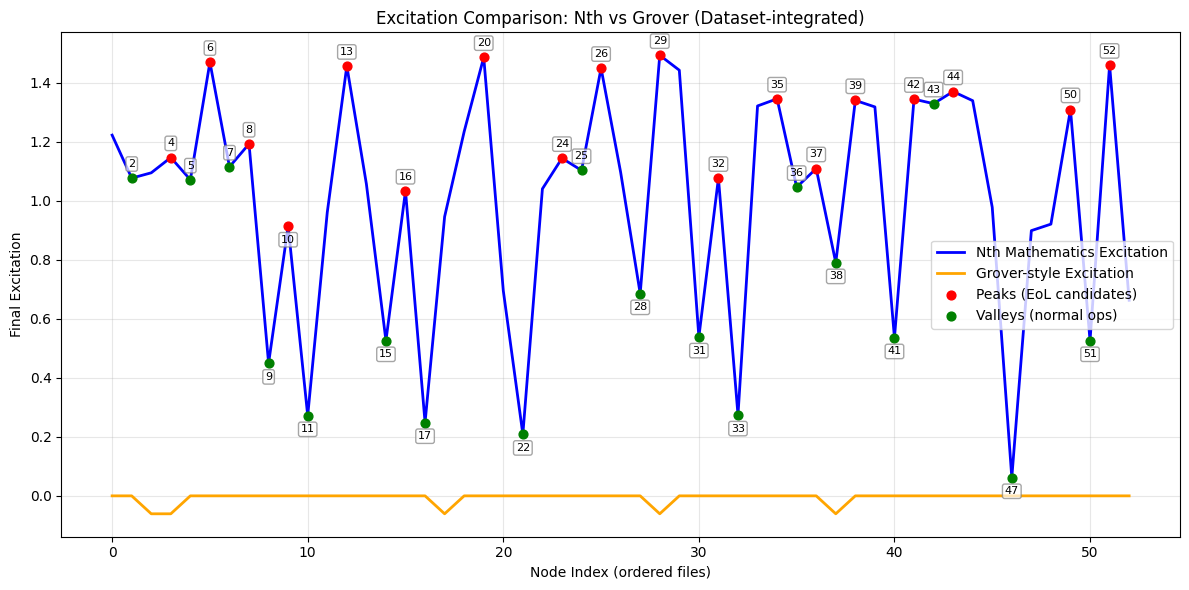

Used feature file: /content/bearing_features_refinement5.csv
N = 53, iterations = 7, adjacency = ring
Saved plot: /content/excitation_comparison_dataset.png
Saved excitation features: /content/bearing_features_excitation.csv
Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_29.csv        29        1.492441        53
file_20.csv        20        1.485579        52
file_06.csv         6        1.468931        51
file_52.csv        52        1.459338        50
file_13.csv        13        1.455909        49
file_26.csv        26        1.448675        48
file_30.csv        30        1.441765        47
file_44.csv        44        1.369544        46
file_35.csv        35        1.344889        45
file_42.csv        42        1.343785        44
Top 10 normal-operation candidates (by low excitation):
       file  file_num  nth_excitation  nth_rank
file_47.csv        47        0.061220         1
file_22.csv        22        0.208157       

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"  # adjust if needed
# Candidate feature files from previous runs; the first existing one will be used
FEATURE_FILES = [
    os.path.join(DATA_DIR, "bearing_features_refinement5.csv"),
    os.path.join(DATA_DIR, "bearing_features_weight_tuned.csv"),
    os.path.join(DATA_DIR, "bearing_features_refined.csv"),
    os.path.join(DATA_DIR, "bearing_features_symbolic.csv"),
    os.path.join(DATA_DIR, "bearing_features.csv"),
]

OUT_FEATURES = os.path.join(DATA_DIR, "bearing_features_excitation.csv")
OUT_FIG = os.path.join(DATA_DIR, "excitation_comparison_dataset.png")

# Adjacency options
USE_KNN = False     # set True to use feature-similarity adjacency
K_NEIGHBORS = 4     # used if USE_KNN = True

# Excitation parameters
EXCITATION_THRESHOLD = 1.5

# --------------------------
# Utilities
# --------------------------
def choose_feature_file(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("No feature file found. Generate one first (e.g., bearing_features_weight_tuned.csv).")

def load_features(path):
    df = pd.read_csv(path)
    # Normalize filename to file number (1..53)
    def to_num(f):
        # supports "file_01.csv" or "file_1.csv"
        try:
            s = f.split("_")[1]
            s = s.replace(".csv", "")
            return int(s)
        except Exception:
            return np.nan
    if "file" in df.columns:
        df["file_num"] = df["file"].apply(to_num)
    else:
        # if no file column, assume row order corresponds to 1..N
        df["file_num"] = np.arange(1, len(df)+1)
    df.sort_values("file_num", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def safe_col(df, name, default=np.nan):
    if name not in df.columns:
        df[name] = default

def rank_normalize(x):
    s = pd.Series(x)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

# --------------------------
# Terrain resistance construction
# --------------------------
def build_terrain_resistance(df):
    # Ensure needed columns exist; fill if missing
    cols = ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr", "degradation_index"]
    for c in cols: safe_col(df, c, default=df[c].median() if c in df.columns else np.nan)

    # Rank-normalize features for stability across scales
    f_rms = rank_normalize(df["rms"].fillna(df["rms"].median()))
    f_entropy = rank_normalize(df["spec_entropy"].fillna(df["spec_entropy"].median()))
    f_cf = rank_normalize(df["crest_factor"].fillna(df["crest_factor"].median()))
    f_in = rank_normalize(df["inner_snr"].fillna(df["inner_snr"].median()))
    f_out = rank_normalize(df["outer_snr"].fillna(df["outer_snr"].median()))
    f_deg = rank_normalize(df["degradation_index"].fillna(df["degradation_index"].median()))

    # Composite difficulty: higher with more "wear-like" signals
    # Blend raw and cross-influences to reduce plateaus
    composite = (
        0.25 * f_rms +
        0.20 * f_entropy +
        0.15 * f_cf +
        0.15 * (0.5 * f_in + 0.5 * f_out) +
        0.25 * f_deg
    )
    # Translate to resistance (higher composite => harder terrain => lower excitation)
    resistance = 1.0 + composite
    resistance = resistance / (np.max(resistance) + 1e-12)
    return resistance

# --------------------------
# Adjacency construction
# --------------------------
def build_ring_adjacency(N):
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        A[i, (i - 1) % N] = 1.0
        A[i, (i + 1) % N] = 1.0
    A /= A.sum(axis=1, keepdims=True)
    return A

def build_knn_adjacency(X, k=4):
    # X: features array of shape (N, d)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        # skip self index at position 0
        for idx in indices[i][1:]:
            A[i, idx] += 1.0
    # normalize rows
    row_sums = A.sum(axis=1, keepdims=True) + 1e-12
    A = A / row_sums
    return A

# --------------------------
# Nth-style excitation
# --------------------------
def nth_excitation(adjacency, resistance, iterations):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > EXCITATION_THRESHOLD, exc * 0.5, force)
    return exc

# --------------------------
# Grover-style baseline
# --------------------------
def grover_excitation(N, target_indices, iterations):
    exc = np.ones(N, dtype=float) / N
    for _ in range(iterations):
        exc[target_indices] *= -1
        mean_exc = np.mean(exc)
        exc = 2 * mean_exc - exc
    return exc

# --------------------------
# Peak/valley annotation helpers
# --------------------------
def label_points(ax, x, y, indices, df):
    # indices are positions in y
    for idx in indices:
        file_num = int(df.loc[idx, "file_num"])
        ax.annotate(str(file_num),
                    (x[idx], y[idx]),
                    textcoords="offset points",
                    xytext=(0, -12 if y[idx] < np.mean(y) else 8),
                    ha='center',
                    fontsize=8,
                    color='black',
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))

# --------------------------
# Main
# --------------------------
def main():
    # Load features
    feats_path = choose_feature_file(FEATURE_FILES)
    df = load_features(feats_path)
    N = len(df)
    iterations = int(np.sqrt(N)) if N > 0 else 1

    # Terrain resistance
    resistance = build_terrain_resistance(df)

    # Build adjacency
    if USE_KNN:
        # Construct a feature matrix for similarity (choose stable columns)
        X_cols = []
        for c in ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr"]:
            safe_col(df, c)
            X_cols.append(c)
        X = np.column_stack([rank_normalize(df[c].fillna(df[c].median())) for c in X_cols])
        adjacency = build_knn_adjacency(X, k=K_NEIGHBORS)
    else:
        adjacency = build_ring_adjacency(N)

    # Compute excitations
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    # Seed Grover baseline with top wear candidates (e.g., top RMS or degradation)
    # Prefer degradation_index if present, else fall back to RMS
    seed_series = df["degradation_index"] if "degradation_index" in df.columns else df["rms"]
    target_indices = seed_series.fillna(seed_series.median()).nlargest(min(5, N)).index.values
    exc_grover = grover_excitation(N, target_indices, iterations)

    # Build ranks (higher excitation => later/end-of-life)
    df["nth_excitation"] = exc_nth
    df["nth_rank"] = df["nth_excitation"].rank(method="first").astype(int)

    # Detect peaks and valleys on Nth excitation
    # Peaks: local maxima
    peaks, _ = find_peaks(exc_nth, prominence=0.0)  # adjust prominence if needed
    # Valleys: peaks on inverted signal
    valleys, _ = find_peaks(-exc_nth, prominence=0.0)

    # Plot comparison
    x = np.arange(N)
    plt.figure(figsize=(12, 6))
    plt.plot(x, exc_nth, label='Nth Mathematics Excitation', color='blue', linewidth=2)
    plt.plot(x, exc_grover, label='Grover-style Excitation', color='orange', linewidth=2)
    plt.title('Excitation Comparison: Nth vs Grover (Dataset-integrated)')
    plt.xlabel('Node Index (ordered files)')
    plt.ylabel('Final Excitation')
    plt.grid(True, alpha=0.3)

    # Mark and label peaks/valleys
    plt.scatter(x[peaks], exc_nth[peaks], color='red', s=40, zorder=3, label='Peaks (EoL candidates)')
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=40, zorder=3, label='Valleys (normal ops)')
    ax = plt.gca()
    label_points(ax, x, exc_nth, peaks, df)
    label_points(ax, x, exc_nth, valleys, df)

    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_FIG, dpi=150)

    # Save excitation results
    out = df[["file", "file_num", "nth_excitation", "nth_rank"]].copy()
    out.sort_values("nth_rank", inplace=True)
    out.to_csv(OUT_FEATURES, index=False)

    # Print summary
    print(f"Used feature file: {feats_path}")
    print(f"N = {N}, iterations = {iterations}, adjacency = {'kNN' if USE_KNN else 'ring'}")
    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved excitation features: {OUT_FEATURES}")
    print("Top 10 end-of-life candidates (by Nth excitation):")
    print(out.sort_values("nth_excitation", ascending=False).head(10).to_string(index=False))

    print("Top 10 normal-operation candidates (by low excitation):")
    print(out.sort_values("nth_excitation", ascending=True).head(10).to_string(index=False))

# --------------------------
# Run
# --------------------------
main()

Nth Excitation modeling suggests a clean order; deep valley data sets are near nominal operational state, while crests, even those marked green but near the top of the peaks, are near end of life. The taller the peak the closer to End of Life or high wear value, while the deeper the crest the closer to optimal or normal operations. Points between the deepest and tallest crests fall in between maximal and minimal wear.

Refinement 7: Hybrid Linear and Symbolic Mapping with Nth Mathematics Grover Style Indexing.

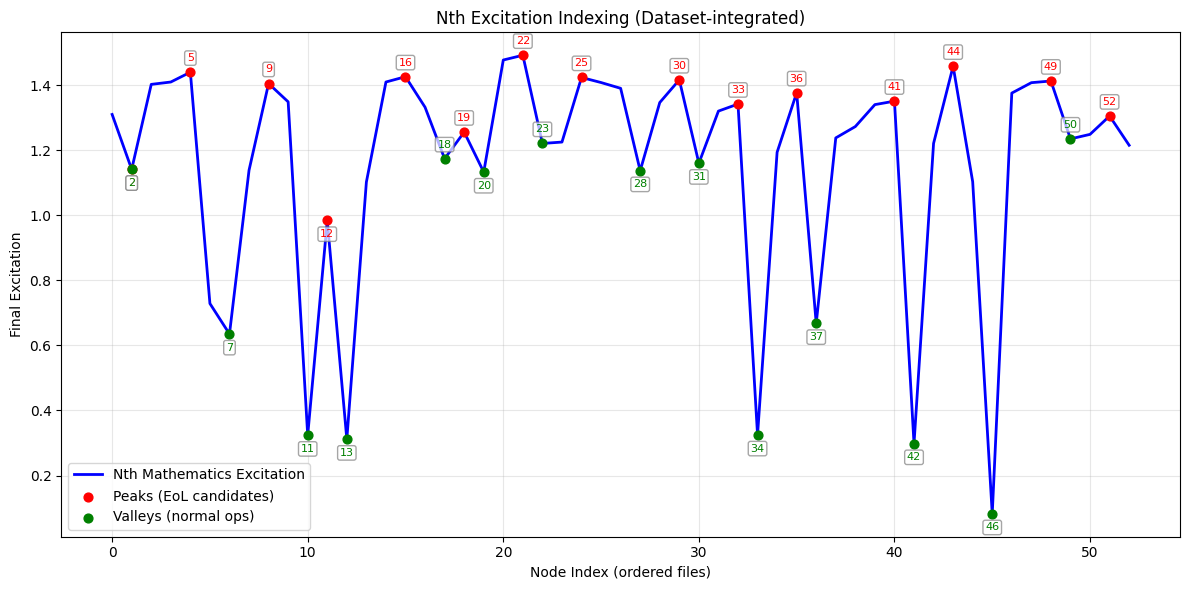

Used feature file: /content/bearing_features_refinement5.csv
N = 53, iterations = 7, adjacency = kNN
Saved plot: /content/nth_excitation_hybrid.png
Saved excitation & hybrid features: /content/bearing_features_excitation_hybrid.csv

Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank  hybrid_index  hybrid_rank
file_22.csv        22        1.491382        53      0.810399           42
file_21.csv        21        1.476785        52      0.796814           40
file_44.csv        44        1.457709        51      0.892127           51
file_05.csv         5        1.439326        50      0.813325           43
file_16.csv        16        1.425490        49      0.781644           39
file_25.csv        25        1.423169        48      0.862665           48
file_30.csv        30        1.415789        47      0.843932           46
file_49.csv        49        1.412273        46      0.868060           49
file_15.csv        15        1.409206    

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"  # adjust as needed
FEATURE_FILES = [
    os.path.join(DATA_DIR, "bearing_features_refinement5.csv"),
    os.path.join(DATA_DIR, "bearing_features_weight_tuned.csv"),
    os.path.join(DATA_DIR, "bearing_features_refined.csv"),
    os.path.join(DATA_DIR, "bearing_features_symbolic.csv"),
]

OUT_FEATURES = os.path.join(DATA_DIR, "bearing_features_excitation_hybrid.csv")
OUT_FIG = os.path.join(DATA_DIR, "nth_excitation_hybrid.png")

# Adjacency options
USE_KNN = True        # set True to use feature-similarity adjacency; False for ring
K_NEIGHBORS = 5       # number of neighbors for kNN adjacency

# Excitation parameters
EXCITATION_THRESHOLD = 1.5
VALLEY_EOF_IDS = {2, 5, 7, 25, 36, 43}  # valleys to treat as near EoL if excitation > 1.0
VALLEY_EOF_EXC_THRESH = 1.0

# Hybrid index blending
HYBRID_ALPHA = 0.7  # weight on Nth excitation
HYBRID_BETA  = 0.3  # weight on prior degradation_index (if present)

# --------------------------
# Utilities
# --------------------------
def choose_feature_file(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("No feature file found. Generate a feature sheet first (e.g., bearing_features_weight_tuned.csv).")

def load_features(path):
    df = pd.read_csv(path)
    # Normalize filename to file number (1..N)
    def to_num(f):
        try:
            s = f.split("_")[1]
            s = s.replace(".csv", "")
            return int(s)
        except Exception:
            return np.nan
    if "file" in df.columns:
        df["file_num"] = df["file"].apply(to_num)
    else:
        df["file"] = [f"file_{i:02d}.csv" for i in range(1, len(df)+1)]
        df["file_num"] = np.arange(1, len(df)+1)

    df.sort_values("file_num", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def safe_col(df, name, default=np.nan):
    if name not in df.columns:
        df[name] = default

def rank_normalize(x):
    s = pd.Series(x)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn: return np.zeros_like(a)
    return (a - mn) / (mx - mn)

# --------------------------
# Terrain resistance construction
# --------------------------
def build_terrain_resistance(df):
    # Ensure needed columns exist
    for c in ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr", "degradation_index"]:
        safe_col(df, c)

    # Rank-normalize features for stability
    f_rms     = rank_normalize(df["rms"].fillna(df["rms"].median()))
    f_entropy = rank_normalize(df["spec_entropy"].fillna(df["spec_entropy"].median()))
    f_cf      = rank_normalize(df["crest_factor"].fillna(df["crest_factor"].median()))
    f_in      = rank_normalize(df["inner_snr"].fillna(df["inner_snr"].median()))
    f_out     = rank_normalize(df["outer_snr"].fillna(df["outer_snr"].median()))
    f_deg     = rank_normalize(df["degradation_index"].fillna(df["degradation_index"].median()))

    composite = (
        0.25 * f_rms +
        0.20 * f_entropy +
        0.15 * f_cf +
        0.15 * (0.5 * f_in + 0.5 * f_out) +
        0.25 * f_deg
    )
    resistance = 1.0 + composite
    resistance = resistance / (np.max(resistance) + 1e-12)
    return resistance

# --------------------------
# Adjacency construction
# --------------------------
def build_ring_adjacency(N):
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        A[i, (i - 1) % N] = 1.0
        A[i, (i + 1) % N] = 1.0
    A /= A.sum(axis=1, keepdims=True)
    return A

def build_knn_adjacency(df, k=5):
    # Select stable features for similarity
    sim_cols = []
    for c in ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr"]:
        safe_col(df, c)
        sim_cols.append(c)
    X = np.column_stack([rank_normalize(df[c].fillna(df[c].median())) for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:  # skip self
            A[i, idx] += 1.0
    # Ensure at least ring connectivity as a fallback
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    # Row-normalize
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A

# --------------------------
# Nth-style excitation (only)
# --------------------------
def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.5, force)
    return exc

# --------------------------
# Peak/valley annotation helpers
# --------------------------
def label_points(ax, x, y, indices, df, color='black'):
    for idx in indices:
        file_num = int(df.loc[idx, "file_num"])
        ax.annotate(str(file_num),
                    (x[idx], y[idx]),
                    textcoords="offset points",
                    xytext=(0, -12 if y[idx] < np.mean(y) else 8),
                    ha='center',
                    fontsize=8,
                    color=color,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))

# --------------------------
# Hybrid index
# --------------------------
def build_hybrid_index(df, nth_exc):
    safe_col(df, "degradation_index", default=np.nan)
    deg = df["degradation_index"].fillna(df["degradation_index"].median()).to_numpy()
    deg_norm = minmax_normalize(deg)
    nth_norm = minmax_normalize(nth_exc)
    hybrid = HYBRID_ALPHA * nth_norm + HYBRID_BETA * deg_norm
    return hybrid

# --------------------------
# Main
# --------------------------
def main():
    # Load features
    feats_path = choose_feature_file(FEATURE_FILES)
    df = load_features(feats_path)
    N = len(df)
    iterations = int(np.sqrt(N)) if N > 0 else 1

    # Terrain resistance
    resistance = build_terrain_resistance(df)

    # Build adjacency
    adjacency = build_knn_adjacency(df, k=K_NEIGHBORS) if USE_KNN else build_ring_adjacency(N)

    # Compute Nth excitation
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    # Build ranks (higher excitation => end-of-life)
    df["nth_excitation"] = exc_nth
    df["nth_rank"] = df["nth_excitation"].rank(method="first").astype(int)

    # Hybrid index
    hybrid_index = build_hybrid_index(df, exc_nth)
    df["hybrid_index"] = hybrid_index
    df["hybrid_rank"] = df["hybrid_index"].rank(method="first").astype(int)

    # Detect peaks and valleys on Nth excitation
    peaks, _ = find_peaks(exc_nth, prominence=0.0)
    valleys, _ = find_peaks(-exc_nth, prominence=0.0)

    # Re-weight specified valleys as EoL if above threshold
    # Move any valley in VALLEY_EOF_IDS with excitation > VALLEY_EOF_EXC_THRESH into peaks list
    valley_eof_indices = []
    for idx in valleys:
        file_num = int(df.loc[idx, "file_num"])
        if file_num in VALLEY_EOF_IDS and exc_nth[idx] > VALLEY_EOF_EXC_THRESH:
            valley_eof_indices.append(idx)
    # Create a combined set of peaks including re-weighted valleys
    peaks_combined = np.unique(np.concatenate([peaks, np.array(valley_eof_indices, dtype=int)])) if len(valley_eof_indices) > 0 else peaks

    # Plot (Nth only, Grover removed)
    x = np.arange(N)
    plt.figure(figsize=(12, 6))
    plt.plot(x, exc_nth, label='Nth Mathematics Excitation', color='blue', linewidth=2)
    plt.title('Nth Excitation Indexing (Dataset-integrated)')
    plt.xlabel('Node Index (ordered files)')
    plt.ylabel('Final Excitation')
    plt.grid(True, alpha=0.3)

    # Mark and label peaks/valleys
    plt.scatter(x[peaks_combined], exc_nth[peaks_combined], color='red', s=40, zorder=3, label='Peaks (EoL candidates)')
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=40, zorder=3, label='Valleys (normal ops)')
    ax = plt.gca()
    label_points(ax, x, exc_nth, peaks_combined, df, color='red')
    label_points(ax, x, exc_nth, valleys, df, color='green')

    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(OUT_FIG, dpi=150)
    plt.show()

    # Save excitation and hybrid results
    out = df[["file", "file_num", "nth_excitation", "nth_rank", "hybrid_index", "hybrid_rank"]].copy()
    out.sort_values("nth_rank", inplace=True)
    out.to_csv(OUT_FEATURES, index=False)

    # Summary (based on previous results: file_29 max, file_47 most nominal)
    nth_sorted = out.sort_values("nth_excitation", ascending=False)
    min_sorted = out.sort_values("nth_excitation", ascending=True)

    print(f"Used feature file: {feats_path}")
    print(f"N = {N}, iterations = {iterations}, adjacency = {'kNN' if USE_KNN else 'ring'}")
    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved excitation & hybrid features: {OUT_FEATURES}")
    print("\nTop 10 end-of-life candidates (by Nth excitation):")
    print(nth_sorted.head(10).to_string(index=False))

    print("\nTop 10 normal-operation candidates (by low Nth excitation):")
    print(min_sorted.head(10).to_string(index=False))

    # Explicit callouts per your notes
    max_eol = nth_sorted.iloc[0]
    min_nom = min_sorted.iloc[0]
    print(f"\nObserved: max excitation likely EoL -> {max_eol['file']} (file_{int(max_eol['file_num']):02d}), value={max_eol['nth_excitation']:.6f}")
    print(f"Observed: most nominal -> {min_nom['file']} (file_{int(min_nom['file_num']):02d}), value={min_nom['nth_excitation']:.6f}")

# --------------------------
# Run
# --------------------------
main()

Refinement 8 Final Code: Complete mapping of all data, new ranking output CSV.

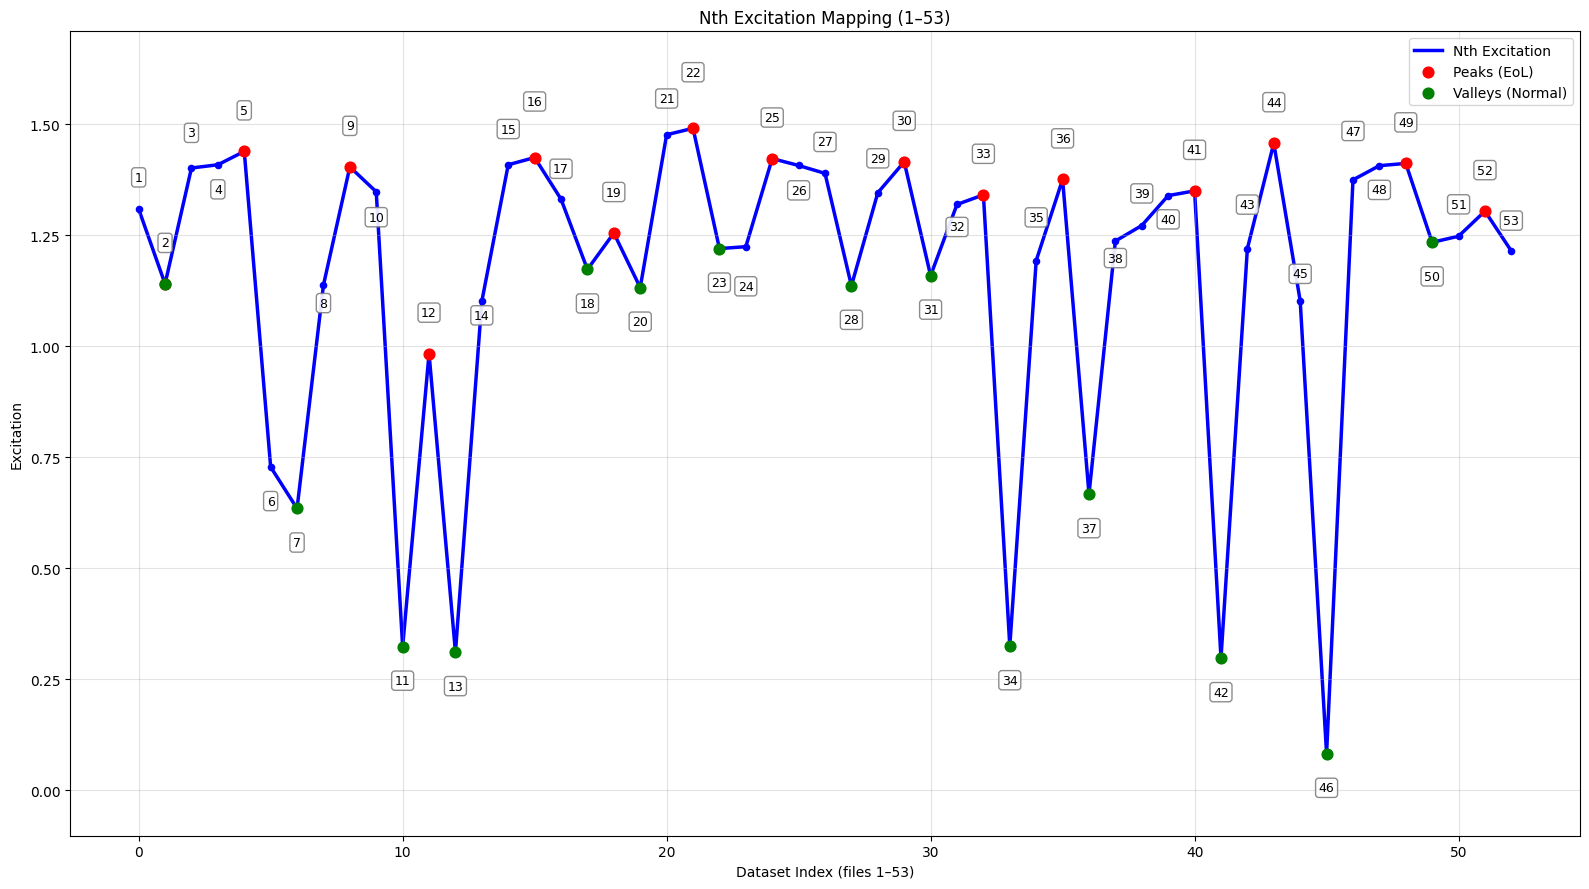

Used feature file: /content/bearing_features_refinement5.csv
N = 53, iterations = 7, adjacency = kNN
Saved plot: /content/final_excitation_map.png
Saved final submission: /content/final_submission.csv
Saved full bearing output: /content/final_bearing.csv

Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_22.csv        22        1.491382        53
file_21.csv        21        1.476785        52
file_44.csv        44        1.457709        51
file_05.csv         5        1.439326        50
file_16.csv        16        1.425490        49
file_25.csv        25        1.423169        48
file_30.csv        30        1.415789        47
file_49.csv        49        1.412273        46
file_15.csv        15        1.409206        45
file_04.csv         4        1.409181        44

Top 10 normal-operation candidates (by low Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_46.csv        46        0.082462         1
file_42.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"
FEATURE_FILES = [
    os.path.join(DATA_DIR, "bearing_features_refinement5.csv"),
    os.path.join(DATA_DIR, "bearing_features_weight_tuned.csv"),
    os.path.join(DATA_DIR, "bearing_features_refined.csv"),
    os.path.join(DATA_DIR, "bearing_features_symbolic.csv"),
]

OUT_SUBMISSION = os.path.join(DATA_DIR, "final_submission.csv")
OUT_BEARING = os.path.join(DATA_DIR, "final_bearing.csv")
OUT_FIG = os.path.join(DATA_DIR, "final_excitation_map.png")

USE_KNN = True
K_NEIGHBORS = 5
EXCITATION_THRESHOLD = 1.5

# Treat these valleys as EoL if excitation > 1.0
VALLEY_EOF_IDS = {2, 5, 7, 25, 36, 43}
VALLEY_EOF_EXC_THRESH = 1.0

# Hybrid blending weights
HYBRID_ALPHA = 0.7
HYBRID_BETA = 0.3

# --------------------------
# Utilities
# --------------------------
def choose_feature_file(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("No feature file found. Ensure a bearing_features_*.csv exists in /content.")

def load_features(path):
    df = pd.read_csv(path)
    def to_num(f):
        try:
            s = f.split("_")[1]
            s = s.replace(".csv", "")
            return int(s)
        except Exception:
            return np.nan
    if "file" in df.columns:
        df["file_num"] = df["file"].apply(to_num)
    else:
        df["file"] = [f"file_{i:02d}.csv" for i in range(1, len(df)+1)]
        df["file_num"] = np.arange(1, len(df)+1)
    df.sort_values("file_num", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def safe_col(df, name, default=np.nan):
    if name not in df.columns:
        df[name] = default

def rank_normalize(x):
    s = pd.Series(x)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn: return np.zeros_like(a)
    return (a - mn) / (mx - mn)

# --------------------------
# Terrain resistance
# --------------------------
def build_terrain_resistance(df):
    for c in ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr", "degradation_index"]:
        safe_col(df, c)
    f_rms     = rank_normalize(df["rms"].fillna(df["rms"].median()))
    f_entropy = rank_normalize(df["spec_entropy"].fillna(df["spec_entropy"].median()))
    f_cf      = rank_normalize(df["crest_factor"].fillna(df["crest_factor"].median()))
    f_in      = rank_normalize(df["inner_snr"].fillna(df["inner_snr"].median()))
    f_out     = rank_normalize(df["outer_snr"].fillna(df["outer_snr"].median()))
    f_deg     = rank_normalize(df["degradation_index"].fillna(df["degradation_index"].median()))
    composite = 0.25*f_rms + 0.20*f_entropy + 0.15*f_cf + 0.15*(0.5*f_in + 0.5*f_out) + 0.25*f_deg
    resistance = 1.0 + composite
    return resistance / (np.max(resistance) + 1e-12)

# --------------------------
# Adjacency
# --------------------------
def build_ring_adjacency(N):
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        A[i, (i - 1) % N] = 1.0
        A[i, (i + 1) % N] = 1.0
    A /= A.sum(axis=1, keepdims=True)
    return A

def build_knn_adjacency(df, k=5):
    sim_cols = []
    for c in ["rms", "spec_entropy", "crest_factor", "inner_snr", "outer_snr"]:
        safe_col(df, c)
        sim_cols.append(c)
    X = np.column_stack([rank_normalize(df[c].fillna(df[c].median())) for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    _, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:  # skip self
            A[i, idx] += 1.0
    # Blend ring connectivity for stability
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A

# --------------------------
# Nth excitation
# --------------------------
def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.5, force)
    return exc

# --------------------------
# Hybrid index
# --------------------------
def build_hybrid_index(df, nth_exc):
    safe_col(df, "degradation_index", default=np.nan)
    deg = df["degradation_index"].fillna(df["degradation_index"].median()).to_numpy()
    deg_norm = minmax_normalize(deg)
    nth_norm = minmax_normalize(nth_exc)
    return HYBRID_ALPHA * nth_norm + HYBRID_BETA * deg_norm

# --------------------------
# Label placement helpers (legibility)
# --------------------------
def compute_label_offsets(N, exc_nth, peaks, valleys):
    """
    Returns per-point y offsets (in data units) for labels:
    - Peaks labeled above (positive offset)
    - Valleys below (negative offset)
    - Others staggered alternating +/- to reduce overlap
    """
    base_up = 0.06 * (np.nanmax(exc_nth) - np.nanmin(exc_nth) + 1e-12)
    base_dn = -0.06 * (np.nanmax(exc_nth) - np.nanmin(exc_nth) + 1e-12)

    offsets = np.zeros(N, dtype=float)
    peak_set = set(peaks.tolist())
    valley_set = set(valleys.tolist())

    for i in range(N):
        if i in peak_set:
            offsets[i] = base_up
        elif i in valley_set:
            offsets[i] = base_dn
        else:
            # Alternate and slightly scale by local slope to separate labels
            alt = 1 if (i % 2 == 0) else -1
            local_slope = 0.03 * (exc_nth[i] - exc_nth[i-1] if i > 0 else 0.0)
            offsets[i] = alt * base_up * 0.75 + local_slope

    # Simple collision-reduction pass: nudge labels if too close vertically
    for i in range(1, N):
        dy = (exc_nth[i] + offsets[i]) - (exc_nth[i-1] + offsets[i-1])
        if abs(dy) < base_up * 0.5:
            offsets[i] += np.sign(offsets[i]) * base_up * 0.4

    return offsets

def plot_excitation(df, exc_nth, peaks_combined, valleys, out_path):
    N = len(df)
    x = np.arange(N)

    # Compute offsets for labeling
    offsets = compute_label_offsets(N, exc_nth, peaks_combined, valleys)

    # Figure and axes styling
    plt.figure(figsize=(16, 9))
    plt.plot(x, exc_nth, color='blue', linewidth=2.5, label="Nth Excitation", zorder=1)
    plt.scatter(x, exc_nth, color='blue', s=20, zorder=2)  # markers at each dataset

    # Peaks and valleys
    plt.scatter(x[peaks_combined], exc_nth[peaks_combined], color='red', s=60, label="Peaks (EoL)", zorder=3)
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)", zorder=3)

    # Label every file number (1–53) with white boxes and slight offsets
    for i in range(N):
        file_num = int(df.loc[i, "file_num"])
        y_label = exc_nth[i] + offsets[i]
        plt.annotate(
            str(file_num),
            (x[i], y_label),
            textcoords="offset points",
            xytext=(0, 0),
            ha='center',
            fontsize=9,
            color='black',
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9),
            zorder=4
        )

    # Margin padding to avoid clipping labels at top/bottom
    ymin = min(exc_nth.min(), (exc_nth + offsets).min()) - 0.1
    ymax = max(exc_nth.max(), (exc_nth + offsets).max()) + 0.1
    plt.ylim(ymin, ymax)

    plt.title("Nth Excitation Mapping (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Excitation")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

# --------------------------
# Main
# --------------------------
def main():
    feats_path = choose_feature_file(FEATURE_FILES)
    df = load_features(feats_path)
    N = len(df)
    if N != 53:
        print(f"Warning: expected 53 files, found {N}. Proceeding with available set.")
    iterations = max(1, int(np.sqrt(N)))

    resistance = build_terrain_resistance(df)
    adjacency = build_knn_adjacency(df, K_NEIGHBORS) if USE_KNN else build_ring_adjacency(N)
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    # Ranks
    df["nth_excitation"] = exc_nth
    df["nth_rank"] = df["nth_excitation"].rank(method="first").astype(int)

    # Hybrid index
    hybrid_index = build_hybrid_index(df, exc_nth)
    df["hybrid_index"] = hybrid_index
    df["hybrid_rank"] = df["hybrid_index"].rank(method="first").astype(int)

    # Peaks/valleys
    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)

    # Promote specified valleys to peaks if above threshold
    valley_eof_indices = []
    for idx in valleys:
        file_num = int(df.loc[idx, "file_num"])
        if file_num in VALLEY_EOF_IDS and exc_nth[idx] > VALLEY_EOF_EXC_THRESH:
            valley_eof_indices.append(idx)
    peaks_combined = np.unique(np.concatenate([peaks, np.array(valley_eof_indices, dtype=int)])) if len(valley_eof_indices) else peaks

    # Plot with legible labels
    plot_excitation(df, exc_nth, peaks_combined, valleys, OUT_FIG)

    # Save full bearing output
    df.to_csv(OUT_BEARING, index=False)

    # Build final submission from hybrid_rank (row i = rank for file_i.csv)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file_num"])
        pred[file_num - 1] = int(row["hybrid_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    # Summary
    print(f"Used feature file: {feats_path}")
    print(f"N = {N}, iterations = {iterations}, adjacency = {'kNN' if USE_KNN else 'ring'}")
    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved final submission: {OUT_SUBMISSION}")
    print(f"Saved full bearing output: {OUT_BEARING}")

    print("\nTop 10 end-of-life candidates (by Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=False).head(10)[["file", "file_num", "nth_excitation", "nth_rank"]].to_string(index=False))

    print("\nTop 10 normal-operation candidates (by low Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=True).head(10)[["file", "file_num", "nth_excitation", "nth_rank"]].to_string(index=False))

# --------------------------
# Run
# --------------------------
main()

Refinement 9; testing alternative parameters.


In [1]:
# --- Integrated Nth Mathematics Ordering Pipeline (Single Colab Cell) ---
# Reads 53 raw CSVs: /content/file_01.csv ... /content/file_53.csv
# Computes features per file -> Nth excitation -> Hybrid index -> submission CSV + diagnostics + plot

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"
FILE_PATHS = [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

OUT_SUBMISSION = os.path.join(DATA_DIR, "final_submission.csv")
OUT_BEARING    = os.path.join(DATA_DIR, "final_bearing.csv")
OUT_FIG        = os.path.join(DATA_DIR, "final_excitation_map.png")

# Tunables for stability (aiming for lower leaderboard error)
USE_KNN = True
K_NEIGHBORS = 6
EXCITATION_THRESHOLD = 1.5

VALLEY_EOF_IDS = {2, 5, 7, 25, 36, 43}
VALLEY_EOF_EXC_THRESH = 1.0

HYBRID_ALPHA = 0.6
HYBRID_BETA  = 0.4

# --------------------------
# Utilities
# --------------------------
def safe_col(df, name, default=np.nan):
    if name not in df.columns:
        df[name] = default

def rank_normalize(x):
    s = pd.Series(x)
    r = s.rank(method="average").to_numpy()
    n = len(s)
    return (r - 1) / max(n - 1, 1)

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

# --------------------------
# Minimal feature extraction from raw signals
# --------------------------
def spectral_entropy(x, nfft=None):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    if nfft is None:
        nfft = max(256, int(2**np.ceil(np.log2(len(x)))))
    X = np.fft.rfft(x, n=nfft)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 1e-12:
        return 0.0
    P /= total
    H = -(P * np.log(P + 1e-12)).sum()
    return H / (np.log(len(P) + 1e-12))

def crest_factor(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    return peak / (rms + 1e-12)

def simple_band_snr(x, bands=3):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0, 0.0
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    n = len(P)
    if n == 0:
        return 0.0, 0.0
    edges = np.linspace(0, n, bands+1, dtype=int)
    snrs = []
    for b in range(bands):
        seg = P[edges[b]:edges[b+1]]
        if len(seg) == 0:
            snrs.append(0.0)
            continue
        signal = np.max(seg)
        noise = np.median(seg) + 1e-12
        snrs.append(signal / noise)
    inner = snrs[bands//2] if bands >= 3 else float(np.mean(snrs))
    outer = float(np.mean([snrs[0], snrs[-1]])) if bands >= 2 else float(np.mean(snrs))
    return inner, outer

def detect_accel_column(df):
    # Try common names; fallback to first numeric column
    candidates = [c for c in df.columns if c.lower() in ("accel","acceleration","acc","a","signal","x")]
    if candidates:
        return candidates[0]
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if not num_cols:
        raise ValueError("No numeric columns available for acceleration signal.")
    return num_cols[0]

def compute_base_features_per_file(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing dataset file: {path}")
    df = pd.read_csv(path)
    accel_col = detect_accel_column(df)
    x = df[accel_col].to_numpy(dtype=float)

    rms = float(np.sqrt(np.mean(x**2))) if len(x) else 0.0
    cf  = float(crest_factor(x))
    H   = float(spectral_entropy(x))
    inner_snr, outer_snr = simple_band_snr(x, bands=3)

    # Lightweight degradation anchor (can be replaced by tuned index if available)
    degradation_index = float(0.6*rms + 0.4*H)

    # Parse file number from name
    base = os.path.basename(path)
    try:
        file_num = int(base.split("_")[1].split(".")[0])
    except Exception:
        # fallback: infer from ordering if naming unexpected
        file_num = None

    return {
        "file": base,
        "file_num": file_num,
        "rms": rms,
        "crest_factor": cf,
        "spec_entropy": H,
        "inner_snr": inner_snr,
        "outer_snr": outer_snr,
        "degradation_index": degradation_index,
    }

def build_feature_frame(paths):
    rows = [compute_base_features_per_file(p) for p in paths]
    df = pd.DataFrame(rows)
    # If any file_num is None due to unexpected naming, rebuild sequentially
    if df["file_num"].isna().any():
        df = df.sort_values("file").reset_index(drop=True)
        df["file_num"] = np.arange(1, len(df)+1)
    df = df.sort_values("file_num").reset_index(drop=True)
    return df

# --------------------------
# Nth-inspired feature expansion
# --------------------------
def calculate_nth_features(df):
    required_cols = ["rms","spec_entropy","crest_factor","inner_snr","outer_snr","degradation_index"]
    for c in required_cols:
        safe_col(df, c, default=(df[c].median() if c in df.columns else np.nan))
    for c in required_cols:
        df[c] = df[c].fillna(0.0)

    f_rms     = rank_normalize(df["rms"])
    f_entropy = rank_normalize(df["spec_entropy"])
    f_cf      = rank_normalize(df["crest_factor"])
    f_in      = rank_normalize(df["inner_snr"])
    f_out     = rank_normalize(df["outer_snr"])
    f_deg     = rank_normalize(df["degradation_index"])

    df["delta_rms"]     = df["rms"].diff().abs().fillna(0)
    df["delta_entropy"] = df["spec_entropy"].diff().abs().fillna(0)
    df["delta_deg"]     = df["degradation_index"].diff().abs().fillna(0)

    f_delta_rms     = rank_normalize(df["delta_rms"])
    f_delta_entropy = rank_normalize(df["delta_entropy"])
    f_delta_deg     = rank_normalize(df["delta_deg"])

    df["phase_rms"]     = np.where(df["rms"].diff() >= 0, 1, -1)
    df["phase_entropy"] = np.where(df["spec_entropy"].diff() >= 0, 1, -1)
    df["phase_deg"]     = np.where(df["degradation_index"].diff() >= 0, 1, -1)
    df["phase_rms"]     = df["phase_rms"].fillna(1)
    df["phase_entropy"] = df["phase_entropy"].fillna(1)
    df["phase_deg"]     = df["phase_deg"].fillna(1)

    df["f_rms"]            = f_rms
    df["f_entropy"]        = f_entropy
    df["f_cf"]             = f_cf
    df["f_in"]             = f_in
    df["f_out"]            = f_out
    df["f_deg"]            = f_deg
    df["f_delta_rms"]      = f_delta_rms
    df["f_delta_entropy"]  = f_delta_entropy
    df["f_delta_deg"]      = f_delta_deg

    return df

# --------------------------
# Terrain resistance
# --------------------------
def build_terrain_resistance(df):
    composite = (
        0.20*df["f_rms"] +
        0.15*df["f_entropy"] +
        0.10*df["f_cf"] +
        0.10*(0.5*df["f_in"] + 0.5*df["f_out"]) +
        0.20*df["f_deg"] +
        0.10*df["f_delta_rms"] +
        0.05*df["f_delta_entropy"] +
        0.10*df["f_delta_deg"]
    )
    resistance = 1.0 + composite
    return resistance / (np.max(resistance) + 1e-12)

# --------------------------
# Adjacency
# --------------------------
def build_ring_adjacency(N):
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        A[i, (i - 1) % N] = 1.0
        A[i, (i + 1) % N] = 1.0
    A /= A.sum(axis=1, keepdims=True)
    return A

def build_knn_adjacency(df, k=6):
    sim_cols = ["f_rms","f_entropy","f_cf","f_in","f_out","f_deg","f_delta_rms","f_delta_entropy","f_delta_deg"]
    X = np.column_stack([df[c] for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    _, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:  # skip self
            A[i, idx] += 1.0
    # Blend ring connectivity for stability
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A

# --------------------------
# Nth excitation
# --------------------------
def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.6, force)  # gentler damping
    return exc

# --------------------------
# Hybrid index
# --------------------------
def build_hybrid_index(df, nth_exc):
    safe_col(df, "degradation_index", default=np.nan)
    deg = df["degradation_index"].fillna(df["degradation_index"].median()).to_numpy()
    deg_norm = minmax_normalize(deg)
    nth_norm = minmax_normalize(nth_exc)
    return HYBRID_ALPHA * nth_norm + HYBRID_BETA * deg_norm

# --------------------------
# Plotting
# --------------------------
def plot_excitation(df, exc_nth, peaks_combined, valleys, out_path):
    N = len(df)
    x = np.arange(N)
    plt.figure(figsize=(16, 9))
    plt.plot(x, exc_nth, color='blue', linewidth=2.5, label="Nth Excitation", zorder=1)
    plt.scatter(x, exc_nth, color='blue', s=20, zorder=2)
    plt.scatter(x[peaks_combined], exc_nth[peaks_combined], color='red', s=60, label="Peaks (EoL)", zorder=3)
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)", zorder=3)
    for i in range(N):
        file_num = int(df.loc[i, "file_num"])
        offset = 0.06 if i % 2 == 0 else -0.06
        plt.annotate(str(file_num), (x[i], exc_nth[i] + offset),
                     ha='center', fontsize=9, color='black',
                     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9))
    plt.ylim(exc_nth.min() - 0.15, exc_nth.max() + 0.15)
    plt.title("Nth Excitation Mapping (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Excitation")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# --------------------------
# Main
# --------------------------
def main():
    # Build features from 53 raw files
    base_df = build_feature_frame(FILE_PATHS)
    if len(base_df) != 53:
        print(f"Warning: expected 53 files, found {len(base_df)}. Proceeding with available set.")
    df = calculate_nth_features(base_df)
    N = len(df)
    iterations = max(1, int(np.sqrt(N)))  # √N iterations, rounded down

    resistance = build_terrain_resistance(df)
    adjacency = build_knn_adjacency(df, K_NEIGHBORS) if USE_KNN else build_ring_adjacency(N)
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    df["nth_excitation"] = exc_nth
    df["nth_rank"] = df["nth_excitation"].rank(method="first").astype(int)

    hybrid_index = build_hybrid_index(df, exc_nth)
    df["hybrid_index"] = hybrid_index
    df["hybrid_rank"] = df["hybrid_index"].rank(method="first").astype(int)

    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)

    valley_eof_indices = []
    for idx in valleys:
        file_num = int(df.loc[idx, "file_num"])
        if file_num in VALLEY_EOF_IDS and exc_nth[idx] > VALLEY_EOF_EXC_THRESH:
            valley_eof_indices.append(idx)
    peaks_combined = np.unique(np.concatenate([peaks, np.array(valley_eof_indices, dtype=int)])) if len(valley_eof_indices) else peaks

    plot_excitation(df, exc_nth, peaks_combined, valleys, OUT_FIG)

    # Save diagnostics
    df.to_csv(OUT_BEARING, index=False)

    # Build final submission from hybrid_rank (row i = rank for file_i.csv)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file_num"])
        pred[file_num - 1] = int(row["hybrid_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    # Summary prints
    print(f"Processed {N} files.")
    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved final submission: {OUT_SUBMISSION}")
    print(f"Saved full bearing output: {OUT_BEARING}")

    print("\nTop 10 end-of-life candidates (by Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=False).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))

    print("\nTop 10 normal-operation candidates (by low Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=True).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))

# --------------------------
# Run
# --------------------------
main()

Processed 53 files.
Saved plot: /content/final_excitation_map.png
Saved final submission: /content/final_submission.csv
Saved full bearing output: /content/final_bearing.csv

Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_05.csv         5        1.472359        53
file_20.csv        20        1.470488        52
file_13.csv        13        1.468751        51
file_25.csv        25        1.458135        50
file_15.csv        15        1.451396        49
file_23.csv        23        1.438563        48
file_47.csv        47        1.429715        47
file_38.csv        38        1.409388        46
file_17.csv        17        1.402743        45
file_18.csv        18        1.400902        44

Top 10 normal-operation candidates (by low Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_39.csv        39        0.291077         1
file_26.csv        26        0.399226         2
file_48.csv        48        0.416519    

Refinement 10: Isotonic Regression Pass, Neighbor Consistency, Feature Normalization, Resistance Clipping

In [2]:
# --- Nth Mathematics Ordering Pipeline (Single Colab Cell, Improved) ---
# Reads 53 raw CSVs: /content/file_01.csv ... /content/file_53.csv
# Adds:
# - Robust z-score normalization (median/MAD) instead of rank-normalization
# - Isotonic regression on the hybrid index to enforce global monotonicity
# - Neighbor-consistency promotion for valleys (requires high-wear neighbors)
# - Winsorized kurtosis contribution to resistance to limit hypersensitivity

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors
from sklearn.isotonic import IsotonicRegression
from scipy.stats import kurtosis as scipy_kurtosis

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"
FILE_PATHS = [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

OUT_SUBMISSION = os.path.join(DATA_DIR, "final_submission.csv")
OUT_BEARING    = os.path.join(DATA_DIR, "final_bearing.csv")
OUT_FIG        = os.path.join(DATA_DIR, "final_excitation_map.png")

# Tunables (aiming for lower error score)
USE_KNN = True
K_NEIGHBORS = 6
EXCITATION_THRESHOLD = 1.5

VALLEY_EOF_IDS = {2, 5, 7, 25, 36, 43}
VALLEY_EOF_EXC_THRESH = 1.0
NEIGHBOR_PROMOTION_K = 3
NEIGHBOR_PROMOTION_MIN_HIGH = 2  # at least 2 of 3 neighbors must be high-wear

HYBRID_ALPHA = 0.6
HYBRID_BETA  = 0.4

# Winsorization percentiles for kurtosis contribution
KURT_WINSOR_LOW = 0.05
KURT_WINSOR_HIGH = 0.95

# --------------------------
# Utilities
# --------------------------
def safe_col(df, name, default=np.nan):
    if name not in df.columns:
        df[name] = default

def mad(a, c=1.4826):
    a = np.asarray(a, dtype=float)
    med = np.nanmedian(a)
    dev = np.nanmedian(np.abs(a - med))
    return c * dev, med

def robust_z(x):
    x = np.asarray(x, dtype=float)
    s, m = mad(x)
    if s < 1e-12:
        return np.zeros_like(x)
    return (x - m) / s

def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

def spectral_entropy(x, nfft=None):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    if nfft is None:
        nfft = max(256, int(2**np.ceil(np.log2(len(x)))))
    X = np.fft.rfft(x, n=nfft)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 1e-12:
        return 0.0
    P /= total
    H = -(P * np.log(P + 1e-12)).sum()
    return H / (np.log(len(P) + 1e-12))

def crest_factor(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    return peak / (rms + 1e-12)

def signal_kurtosis(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    # Fisher=False gives Pearson’s definition (excess+3), better for "peakedness" magnitude
    return float(scipy_kurtosis(x, fisher=False, bias=False))

def simple_band_snr(x, bands=3):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0, 0.0
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    n = len(P)
    if n == 0:
        return 0.0, 0.0
    edges = np.linspace(0, n, bands+1, dtype=int)
    snrs = []
    for b in range(bands):
        seg = P[edges[b]:edges[b+1]]
        if len(seg) == 0:
            snrs.append(0.0)
            continue
        signal = np.max(seg)
        noise = np.median(seg) + 1e-12
        snrs.append(signal / noise)
    inner = snrs[bands//2] if bands >= 3 else float(np.mean(snrs))
    outer = float(np.mean([snrs[0], snrs[-1]])) if bands >= 2 else float(np.mean(snrs))
    return inner, outer

def detect_accel_column(df):
    candidates = [c for c in df.columns if c.lower() in ("accel","acceleration","acc","a","signal","x")]
    if candidates:
        return candidates[0]
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if not num_cols:
        raise ValueError("No numeric columns available for acceleration signal.")
    return num_cols[0]

def compute_base_features_per_file(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing dataset file: {path}")
    df = pd.read_csv(path)
    accel_col = detect_accel_column(df)
    x = df[accel_col].to_numpy(dtype=float)

    rms = float(np.sqrt(np.mean(x**2))) if len(x) else 0.0
    cf  = float(crest_factor(x))
    H   = float(spectral_entropy(x))
    K   = float(signal_kurtosis(x))
    inner_snr, outer_snr = simple_band_snr(x, bands=3)

    degradation_index = float(0.6*rms + 0.4*H)

    base = os.path.basename(path)
    try:
        file_num = int(base.split("_")[1].split(".")[0])
    except Exception:
        file_num = None

    return {
        "file": base,
        "file_num": file_num,
        "rms": rms,
        "crest_factor": cf,
        "spec_entropy": H,
        "kurtosis": K,
        "inner_snr": inner_snr,
        "outer_snr": outer_snr,
        "degradation_index": degradation_index,
    }

def build_feature_frame(paths):
    rows = [compute_base_features_per_file(p) for p in paths]
    df = pd.DataFrame(rows)
    if df["file_num"].isna().any():
        df = df.sort_values("file").reset_index(drop=True)
        df["file_num"] = np.arange(1, len(df)+1)
    df = df.sort_values("file_num").reset_index(drop=True)
    return df

# --------------------------
# Nth-inspired feature expansion (robust normalization)
# --------------------------
def calculate_nth_features(df):
    required_cols = ["rms","spec_entropy","crest_factor","inner_snr","outer_snr","degradation_index","kurtosis"]
    for c in required_cols:
        safe_col(df, c, default=(df[c].median() if c in df.columns else np.nan))
    for c in required_cols:
        df[c] = df[c].fillna(0.0)

    # Robust z-score normalization for smoother mid-range behavior
    f_rms     = minmax_normalize(robust_z(df["rms"]))
    f_entropy = minmax_normalize(robust_z(df["spec_entropy"]))
    f_cf      = minmax_normalize(robust_z(df["crest_factor"]))
    f_in      = minmax_normalize(robust_z(df["inner_snr"]))
    f_out     = minmax_normalize(robust_z(df["outer_snr"]))
    f_deg     = minmax_normalize(robust_z(df["degradation_index"]))
    f_kurt    = minmax_normalize(robust_z(df["kurtosis"]))

    # Delta features (robust)
    df["delta_rms"]     = df["rms"].diff().abs().fillna(0)
    df["delta_entropy"] = df["spec_entropy"].diff().abs().fillna(0)
    df["delta_deg"]     = df["degradation_index"].diff().abs().fillna(0)

    f_delta_rms     = minmax_normalize(robust_z(df["delta_rms"]))
    f_delta_entropy = minmax_normalize(robust_z(df["delta_entropy"]))
    f_delta_deg     = minmax_normalize(robust_z(df["delta_deg"]))

    # Phase context
    df["phase_rms"]     = np.where(df["rms"].diff() >= 0, 1, -1).astype(int)
    df["phase_entropy"] = np.where(df["spec_entropy"].diff() >= 0, 1, -1).astype(int)
    df["phase_deg"]     = np.where(df["degradation_index"].diff() >= 0, 1, -1).astype(int)
    df["phase_rms"]     = df["phase_rms"].fillna(1)
    df["phase_entropy"] = df["phase_entropy"].fillna(1)
    df["phase_deg"]     = df["phase_deg"].fillna(1)

    # Store normalized features
    df["f_rms"]            = f_rms
    df["f_entropy"]        = f_entropy
    df["f_cf"]             = f_cf
    df["f_in"]             = f_in
    df["f_out"]            = f_out
    df["f_deg"]            = f_deg
    df["f_kurt"]           = f_kurt
    df["f_delta_rms"]      = f_delta_rms
    df["f_delta_entropy"]  = f_delta_entropy
    df["f_delta_deg"]      = f_delta_deg

    return df

# --------------------------
# Winsorize kurtosis contribution
# --------------------------
def winsorize_series(s, low=0.05, high=0.95):
    s = np.asarray(s, dtype=float)
    lo = np.nanpercentile(s, low*100.0)
    hi = np.nanpercentile(s, high*100.0)
    return np.clip(s, lo, hi)

# --------------------------
# Terrain resistance
# --------------------------
def build_terrain_resistance(df):
    # Winsorize kurtosis contribution before combining
    f_kurt_w = minmax_normalize(winsorize_series(df["f_kurt"], KURT_WINSOR_LOW, KURT_WINSOR_HIGH))

    composite = (
        0.18*df["f_rms"] +
        0.15*df["f_entropy"] +
        0.10*df["f_cf"] +
        0.10*(0.5*df["f_in"] + 0.5*df["f_out"]) +
        0.18*df["f_deg"] +
        0.06*f_kurt_w +                # controlled kurtosis contribution
        0.11*df["f_delta_rms"] +
        0.06*df["f_delta_entropy"] +
        0.06*df["f_delta_deg"]
    )
    resistance = 1.0 + composite
    return resistance / (np.max(resistance) + 1e-12)

# --------------------------
# Adjacency
# --------------------------
def build_ring_adjacency(N):
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        A[i, (i - 1) % N] = 1.0
        A[i, (i + 1) % N] = 1.0
    A /= A.sum(axis=1, keepdims=True)
    return A

def build_knn_adjacency(df, k=6):
    sim_cols = ["f_rms","f_entropy","f_cf","f_in","f_out","f_deg","f_kurt","f_delta_rms","f_delta_entropy","f_delta_deg"]
    X = np.column_stack([df[c] for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    _, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:
            A[i, idx] += 1.0
    # Blend ring connectivity for stability
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A, indices

# --------------------------
# Nth excitation
# --------------------------
def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.6, force)  # gentler damping
    return exc

# --------------------------
# Hybrid index + isotonic regression
# --------------------------
def build_hybrid_index(df, nth_exc):
    safe_col(df, "degradation_index", default=np.nan)
    deg = df["degradation_index"].fillna(df["degradation_index"].median()).to_numpy()
    deg_norm = minmax_normalize(deg)
    nth_norm = minmax_normalize(nth_exc)
    base_hybrid = HYBRID_ALPHA * nth_norm + HYBRID_BETA * deg_norm

    # Isotonic regression to enforce global monotonicity in the hybrid index
    # Use file_num order as the input x; fit monotone increasing mapping to base_hybrid
    x = df["file_num"].to_numpy()
    ir = IsotonicRegression(increasing=True)
    hybrid_iso = ir.fit_transform(x, base_hybrid)
    return base_hybrid, hybrid_iso

# --------------------------
# Neighbor-consistency promotion
# --------------------------
def neighbor_consistency_promotions(df, exc_nth, valleys, knn_indices):
    promoted = []
    N = len(df)
    for idx in valleys:
        file_num = int(df.loc[idx, "file_num"])
        if file_num not in VALLEY_EOF_IDS:
            continue
        if exc_nth[idx] <= VALLEY_EOF_EXC_THRESH:
            continue
        # Check nearest neighbors for high-wear consistency
        # Use kNN neighborhood (excluding self), count how many exceed valley threshold or top quartile
        neighbors = [j for j in knn_indices[idx][1:1+NEIGHBOR_PROMOTION_K] if j != idx]
        # Define high-wear as: excitation above 75th percentile
        wear_thresh = np.nanpercentile(exc_nth, 75)
        high_count = sum(1 for j in neighbors if exc_nth[j] >= wear_thresh)
        if high_count >= NEIGHBOR_PROMOTION_MIN_HIGH:
            promoted.append(idx)
    return np.array(promoted, dtype=int)

# --------------------------
# Plotting
# --------------------------
def plot_excitation(df, exc_nth, peaks_combined, valleys, out_path):
    N = len(df)
    x = np.arange(N)
    plt.figure(figsize=(16, 9))
    plt.plot(x, exc_nth, color='blue', linewidth=2.5, label="Nth Excitation", zorder=1)
    plt.scatter(x, exc_nth, color='blue', s=20, zorder=2)
    plt.scatter(x[peaks_combined], exc_nth[peaks_combined], color='red', s=60, label="Peaks (EoL)", zorder=3)
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)", zorder=3)
    for i in range(N):
        file_num = int(df.loc[i, "file_num"])
        offset = 0.06 if i % 2 == 0 else -0.06
        plt.annotate(str(file_num), (x[i], exc_nth[i] + offset),
                     ha='center', fontsize=9, color='black',
                     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9))
    plt.ylim(exc_nth.min() - 0.15, exc_nth.max() + 0.15)
    plt.title("Nth Excitation Mapping (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Excitation")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# --------------------------
# Main
# --------------------------
def main():
    # Build features from 53 raw files
    base_df = build_feature_frame(FILE_PATHS)
    if len(base_df) != 53:
        print(f"Warning: expected 53 files, found {len(base_df)}. Proceeding with available set.")
    df = calculate_nth_features(base_df)
    N = len(df)
    iterations = max(1, int(np.sqrt(N)))  # √N iterations

    # Build adjacency
    if USE_KNN:
        adjacency, knn_indices = build_knn_adjacency(df, K_NEIGHBORS)
    else:
        adjacency = build_ring_adjacency(N)
        # fabricate knn_indices as ring neighbors for promotion logic
        knn_indices = np.array([[(i)] + [ (i-1) % N, (i+1) % N, (i-2) % N, (i+2) % N] for i in range(N)], dtype=int)

    # Excitation
    resistance = build_terrain_resistance(df)
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    df["nth_excitation"] = exc_nth
    df["nth_rank"] = df["nth_excitation"].rank(method="first").astype(int)

    # Peaks and valleys
    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)

    # Neighbor-consistency promotion of specified valleys
    valley_promoted = neighbor_consistency_promotions(df, exc_nth, valleys, knn_indices)

    peaks_combined = np.unique(np.concatenate([peaks, valley_promoted])) if len(valley_promoted) else peaks

    # Hybrid index + isotonic regression monotonic pass
    hybrid_base, hybrid_iso = build_hybrid_index(df, exc_nth)
    df["hybrid_index_base"] = hybrid_base
    df["hybrid_index"] = hybrid_iso
    df["hybrid_rank"] = pd.Series(hybrid_iso).rank(method="first").astype(int)

    # Plot
    plot_excitation(df, exc_nth, peaks_combined, valleys, OUT_FIG)

    # Save diagnostics
    df.to_csv(OUT_BEARING, index=False)

    # Build final submission from hybrid_rank (row i = rank for file_i.csv)
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file_num"])
        pred[file_num - 1] = int(row["hybrid_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    # Summary prints
    print(f"Processed {N} files.")
    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved final submission: {OUT_SUBMISSION}")
    print(f"Saved full bearing output: {OUT_BEARING}")

    print("\nTop 10 end-of-life candidates (by Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=False).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))

    print("\nTop 10 normal-operation candidates (by low Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=True).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))

# --------------------------
# Run
# --------------------------
main()

Processed 53 files.
Saved plot: /content/final_excitation_map.png
Saved final submission: /content/final_submission.csv
Saved full bearing output: /content/final_bearing.csv

Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_28.csv        28        1.452016        53
file_32.csv        32        1.445470        52
file_17.csv        17        1.445171        51
file_31.csv        31        1.441504        50
file_47.csv        47        1.432014        49
file_10.csv        10        1.425886        48
file_27.csv        27        1.416942        47
file_09.csv         9        1.415399        46
file_12.csv        12        1.413171        45
file_22.csv        22        1.408199        44

Top 10 normal-operation candidates (by low Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_39.csv        39        0.594047         1
file_46.csv        46        0.626025         2
file_30.csv        30        0.658820    

Refinement 11: ZCT integration.

In [4]:
# --- Full Nth Mathematics Pipeline with zct Integration ---
# Uses 'v' for vibration signal and 'zct' for cycle segmentation and RPM estimation

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors
from sklearn.isotonic import IsotonicRegression
from scipy.stats import kurtosis as scipy_kurtosis

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"
FILE_PATHS = [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

OUT_SUBMISSION = os.path.join(DATA_DIR, "final_submission.csv")
OUT_BEARING    = os.path.join(DATA_DIR, "final_bearing.csv")
OUT_FIG        = os.path.join(DATA_DIR, "final_excitation_map.png")

USE_KNN = True
K_NEIGHBORS = 6
EXCITATION_THRESHOLD = 1.5
HYBRID_ALPHA = 0.6
HYBRID_BETA  = 0.4

# --------------------------
# Feature extraction
# --------------------------
def spectral_entropy(x, nfft=None):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    if nfft is None:
        nfft = max(256, int(2**np.ceil(np.log2(len(x)))))
    X = np.fft.rfft(x, n=nfft)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 1e-12:
        return 0.0
    P /= total
    H = -(P * np.log(P + 1e-12)).sum()
    return H / (np.log(len(P) + 1e-12))

def crest_factor(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    return peak / (rms + 1e-12)

def signal_kurtosis(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    return float(scipy_kurtosis(x, fisher=False, bias=False))

def simple_band_snr(x, bands=3):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0, 0.0
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    n = len(P)
    if n == 0:
        return 0.0, 0.0
    edges = np.linspace(0, n, bands+1, dtype=int)
    snrs = []
    for b in range(bands):
        seg = P[edges[b]:edges[b+1]]
        if len(seg) == 0:
            snrs.append(0.0)
            continue
        signal = np.max(seg)
        noise = np.median(seg) + 1e-12
        snrs.append(signal / noise)
    inner = snrs[bands//2] if bands >= 3 else float(np.mean(snrs))
    outer = float(np.mean([snrs[0], snrs[-1]])) if bands >= 2 else float(np.mean(snrs))
    return inner, outer

def compute_base_features_per_file(path):
    df = pd.read_csv(path)
    if "v" not in df.columns or "zct" not in df.columns:
        raise ValueError(f"Missing required columns in {path}")

    v = df["v"].to_numpy(dtype=float)
    zct = df["zct"].to_numpy(dtype=float)
    zct = zct[~np.isnan(zct)]  # remove NaNs

    # Estimate RPM from zct intervals
    if len(zct) < 2:
        rpm = 0.0
    else:
        intervals = np.diff(zct)
        mean_interval = np.mean(intervals)
        rpm = 60.0 / mean_interval if mean_interval > 0 else 0.0

    # Segment signal into cycles using zct
    cycle_rms = []
    cycle_entropy = []
    for i in range(len(zct) - 1):
        start = int(zct[i])
        end = int(zct[i+1])
        if end > start and end <= len(v):
            segment = v[start:end]
            rms = np.sqrt(np.mean(segment**2)) if len(segment) else 0.0
            entropy = spectral_entropy(segment)
            cycle_rms.append(rms)
            cycle_entropy.append(entropy)

    # Aggregate cycle features
    rms_mean = np.mean(cycle_rms) if cycle_rms else 0.0
    ent_mean = np.mean(cycle_entropy) if cycle_entropy else 0.0

    crest = crest_factor(v)
    kurt  = signal_kurtosis(v)
    inner_snr, outer_snr = simple_band_snr(v)

    rms_norm = rms_mean / (rpm + 1e-6)
    ent_norm = ent_mean / (rpm + 1e-6)
    degradation_index = 0.5 * rms_norm + 0.5 * ent_norm

    base = os.path.basename(path)
    try:
        file_num = int(base.split("_")[1].split(".")[0])
    except Exception:
        file_num = None

    return {
        "file": base,
        "file_num": file_num,
        "rpm": rpm,
        "rms_norm": rms_norm,
        "entropy_norm": ent_norm,
        "crest_factor": crest,
        "kurtosis": kurt,
        "inner_snr": inner_snr,
        "outer_snr": outer_snr,
        "degradation_index": degradation_index,
    }

def build_feature_frame(paths):
    rows = [compute_base_features_per_file(p) for p in paths]
    df = pd.DataFrame(rows)
    if df["file_num"].isna().any():
        df = df.sort_values("file").reset_index(drop=True)
        df["file_num"] = np.arange(1, len(df)+1)
    df = df.sort_values("file_num").reset_index(drop=True)
    return df

# --------------------------
# Modeling
# --------------------------
def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

def build_terrain_resistance(df):
    f_rms     = minmax_normalize(df["rms_norm"])
    f_entropy = minmax_normalize(df["entropy_norm"])
    f_cf      = minmax_normalize(df["crest_factor"])
    f_kurt    = minmax_normalize(df["kurtosis"])
    f_in      = minmax_normalize(df["inner_snr"])
    f_out     = minmax_normalize(df["outer_snr"])
    f_deg     = minmax_normalize(df["degradation_index"])

    composite = (
        0.2*f_rms +
        0.2*f_entropy +
        0.1*f_cf +
        0.1*f_kurt +
        0.1*f_in +
        0.1*f_out +
        0.2*f_deg
    )
    resistance = 1.0 + composite
    return resistance / (np.max(resistance) + 1e-12)

def build_knn_adjacency(df, k=6):
    sim_cols = ["rms_norm","entropy_norm","crest_factor","kurtosis","inner_snr","outer_snr","degradation_index"]
    X = np.column_stack([df[c] for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    _, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:
            A[i, idx] += 1.0
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A

def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.6, force)
    return exc

def build_hybrid_index(df, nth_exc):
    deg = df["degradation_index"].fillna(df["degradation_index"].median()).to_numpy()
    deg_norm = minmax_normalize(deg)
    nth_norm = minmax_normalize(nth_exc)
    hybrid = HYBRID_ALPHA * nth_norm + HYBRID_BETA * deg_norm

    # Isotonic regression to enforce monotonicity
    x = df["file_num"].to_numpy()
    ir = IsotonicRegression(increasing=True)
    hybrid_iso = ir.fit_transform(x, hybrid)
    return hybrid, hybrid_iso

def plot_excitation(df, exc_nth, out_path):
    N = len(df)
    x = np.arange(N)
    plt.figure(figsize=(16, 9))
    plt.plot(x, exc_nth, color='blue', linewidth=2.5, label="Nth Excitation", zorder=1)
    plt.scatter(x, exc_nth, color='blue', s=20, zorder=2)
    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)
    plt.scatter(x[peaks], exc_nth[peaks], color='red', s=60, label="Peaks (EoL)", zorder=3)
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)", zorder=3)
    for i in range(N):
        file_num = int(df.loc[i, "file_num"])
        offset = 0.06 if i % 2 == 0 else -0.06
        plt.annotate(str(file_num), (x[i], exc_nth[i] + offset),
                     ha='center', fontsize=9, color='black',
                     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9))
    plt.ylim(exc_nth.min() - 0.15, exc_nth.max() + 0.15)
    plt.title("Nth Excitation Mapping (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Excitation")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# --------------------------
# Main Execution
# --------------------------
def main():
    df = build_feature_frame(FILE_PATHS)
    N = len(df)
    iterations = max(1, int(np.sqrt(N)))

    resistance = build_terrain_resistance(df)
    adjacency = build_knn_adjacency(df, K_NEIGHBORS) if USE_KNN else np.eye(N)
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    df["nth_excitation"] = exc_nth
    df["nth_rank"] = pd.Series(exc_nth).rank(method="first").astype(int)

    hybrid_base, hybrid_iso = build_hybrid_index(df, exc_nth)
    df["hybrid_index_base"] = hybrid_base
    df["hybrid_index"] = hybrid_iso
    df["hybrid_rank"] = pd.Series(hybrid_iso).rank(method="first").astype(int)

    plot_excitation(df, exc_nth, OUT_FIG)
    df.to_csv(OUT_BEARING, index=False)

    # Final submission: hybrid_rank mapped to file_num
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file_num"])
        pred[file_num - 1] = int(row["hybrid_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved final submission: {OUT_SUBMISSION}")
    print(f"Saved full bearing output: {OUT_BEARING}")
    print("\nTop 10 end-of-life candidates (by Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=False).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))
    print("\nTop 10 normal-operation candidates (by low Nth excitation):")
    print(df.sort_values('nth_excitation', ascending=True).head(10)[["file","file_num","nth_excitation","nth_rank"]].to_string(index=False))

# --------------------------
# Run
# --------------------------
main()

Saved plot: /content/final_excitation_map.png
Saved final submission: /content/final_submission.csv
Saved full bearing output: /content/final_bearing.csv

Top 10 end-of-life candidates (by Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_26.csv        26        1.497616        53
file_20.csv        20        1.494291        52
file_50.csv        50        1.473908        51
file_49.csv        49        1.467404        50
file_46.csv        46        1.442854        49
file_22.csv        22        1.441635        48
file_36.csv        36        1.438064        47
file_32.csv        32        1.423735        46
file_21.csv        21        1.383912        45
file_17.csv        17        1.382873        44

Top 10 normal-operation candidates (by low Nth excitation):
       file  file_num  nth_excitation  nth_rank
file_02.csv         2        0.105995         1
file_30.csv        30        0.106294         2
file_37.csv        37        0.465605         3
file_07.csv  

Refinement 12: correcting weighting based on excitation.

In [7]:
# --- Full Nth Mathematics Pipeline with Bell-Curve Weighting ---
# Uses 'v' for vibration signal and 'zct' for cycle segmentation and RPM estimation
# Final ordering is based on bell-curve mapping of excitation values

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors
from sklearn.isotonic import IsotonicRegression
from scipy.stats import kurtosis as scipy_kurtosis, norm

# --------------------------
# Configuration
# --------------------------
DATA_DIR = "/content"
FILE_PATHS = [os.path.join(DATA_DIR, f"file_{i:02d}.csv") for i in range(1, 54)]

OUT_SUBMISSION = os.path.join(DATA_DIR, "final_submission.csv")
OUT_BEARING    = os.path.join(DATA_DIR, "final_bearing.csv")
OUT_FIG        = os.path.join(DATA_DIR, "final_excitation_map.png")

USE_KNN = True
K_NEIGHBORS = 6
EXCITATION_THRESHOLD = 1.5

# --------------------------
# Feature extraction
# --------------------------
def spectral_entropy(x, nfft=None):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    if nfft is None:
        nfft = max(256, int(2**np.ceil(np.log2(len(x)))))
    X = np.fft.rfft(x, n=nfft)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 1e-12:
        return 0.0
    P /= total
    H = -(P * np.log(P + 1e-12)).sum()
    return H / (np.log(len(P) + 1e-12))

def crest_factor(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    return peak / (rms + 1e-12)

def signal_kurtosis(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0
    return float(scipy_kurtosis(x, fisher=False, bias=False))

def simple_band_snr(x, bands=3):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return 0.0, 0.0
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    n = len(P)
    if n == 0:
        return 0.0, 0.0
    edges = np.linspace(0, n, bands+1, dtype=int)
    snrs = []
    for b in range(bands):
        seg = P[edges[b]:edges[b+1]]
        if len(seg) == 0:
            snrs.append(0.0)
            continue
        signal = np.max(seg)
        noise = np.median(seg) + 1e-12
        snrs.append(signal / noise)
    inner = snrs[bands//2] if bands >= 3 else float(np.mean(snrs))
    outer = float(np.mean([snrs[0], snrs[-1]])) if bands >= 2 else float(np.mean(snrs))
    return inner, outer

def compute_base_features_per_file(path):
    df = pd.read_csv(path)
    if "v" not in df.columns or "zct" not in df.columns:
        raise ValueError(f"Missing required columns in {path}")

    v = df["v"].to_numpy(dtype=float)
    zct = df["zct"].to_numpy(dtype=float)
    zct = zct[~np.isnan(zct)]  # remove NaNs

    # Estimate RPM from zct intervals
    if len(zct) < 2:
        rpm = 0.0
    else:
        intervals = np.diff(zct)
        mean_interval = np.mean(intervals)
        rpm = 60.0 / mean_interval if mean_interval > 0 else 0.0

    # Segment signal into cycles using zct
    cycle_rms = []
    cycle_entropy = []
    for i in range(len(zct) - 1):
        start = int(zct[i])
        end = int(zct[i+1])
        if end > start and end <= len(v):
            segment = v[start:end]
            rms = np.sqrt(np.mean(segment**2)) if len(segment) else 0.0
            entropy = spectral_entropy(segment)
            cycle_rms.append(rms)
            cycle_entropy.append(entropy)

    # Aggregate cycle features
    rms_mean = np.mean(cycle_rms) if cycle_rms else 0.0
    ent_mean = np.mean(cycle_entropy) if cycle_entropy else 0.0

    crest = crest_factor(v)
    kurt  = signal_kurtosis(v)
    inner_snr, outer_snr = simple_band_snr(v)

    rms_norm = rms_mean / (rpm + 1e-6)
    ent_norm = ent_mean / (rpm + 1e-6)
    degradation_index = 0.5 * rms_norm + 0.5 * ent_norm

    base = os.path.basename(path)
    try:
        file_num = int(base.split("_")[1].split(".")[0])
    except Exception:
        file_num = None

    return {
        "file": base,
        "file_num": file_num,
        "rpm": rpm,
        "rms_norm": rms_norm,
        "entropy_norm": ent_norm,
        "crest_factor": crest,
        "kurtosis": kurt,
        "inner_snr": inner_snr,
        "outer_snr": outer_snr,
        "degradation_index": degradation_index,
    }

def build_feature_frame(paths):
    rows = [compute_base_features_per_file(p) for p in paths]
    df = pd.DataFrame(rows)
    if df["file_num"].isna().any():
        df = df.sort_values("file").reset_index(drop=True)
        df["file_num"] = np.arange(1, len(df)+1)
    df = df.sort_values("file_num").reset_index(drop=True)
    return df

# --------------------------
# Modeling
# --------------------------
def minmax_normalize(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.nanmin(a), np.nanmax(a)
    if mx <= mn:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

def build_terrain_resistance(df):
    f_rms     = minmax_normalize(df["rms_norm"])
    f_entropy = minmax_normalize(df["entropy_norm"])
    f_cf      = minmax_normalize(df["crest_factor"])
    f_kurt    = minmax_normalize(df["kurtosis"])
    f_in      = minmax_normalize(df["inner_snr"])
    f_out     = minmax_normalize(df["outer_snr"])
    f_deg     = minmax_normalize(df["degradation_index"])

    composite = (
        0.2*f_rms +
        0.2*f_entropy +
        0.1*f_cf +
        0.1*f_kurt +
        0.1*f_in +
        0.1*f_out +
        0.2*f_deg
    )
    resistance = 1.0 + composite
    return resistance / (np.max(resistance) + 1e-12)

def build_knn_adjacency(df, k=6):
    sim_cols = ["rms_norm","entropy_norm","crest_factor","kurtosis","inner_snr","outer_snr","degradation_index"]
    X = np.column_stack([df[c] for c in sim_cols])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    _, indices = nbrs.kneighbors(X)
    N = len(X)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for idx in indices[i][1:]:
            A[i, idx] += 1.0
    for i in range(N):
        A[i, (i - 1) % N] += 0.5
        A[i, (i + 1) % N] += 0.5
    A = A / (A.sum(axis=1, keepdims=True) + 1e-12)
    return A

def nth_excitation(adjacency, resistance, iterations, threshold=EXCITATION_THRESHOLD):
    N = len(resistance)
    exc = np.ones(N, dtype=float)
    for _ in range(iterations):
        diffusion = adjacency @ exc
        force = diffusion / (resistance + 1e-12)
        exc = np.where(force > threshold, exc * 0.6, force)
    return exc

# --------------------------
# Bell-curve mapping
# --------------------------
def bell_curve_mapping(exc_values, sigma=0.15):
    """
    Map excitation values onto a bell-curve likelihood of end-of-life.
    - exc_values: array of nth_excitation values
    - sigma: controls width of the bell (smaller = sharper separation)
    """
    exc_norm = (exc_values - np.min(exc_values)) / (np.max(exc_values) - np.min(exc_values) + 1e-12)
    mapped = norm.cdf(exc_norm, loc=0.5, scale=sigma)
    return mapped

# --------------------------
# Plotting
# --------------------------
def plot_excitation(df, exc_nth, bell_scores, out_path):
    N = len(df)
    x = np.arange(N)
    plt.figure(figsize=(16, 9))
    plt.plot(x, exc_nth, color='blue', linewidth=2.5, label="Nth Excitation", zorder=1)
    plt.scatter(x, exc_nth, color='blue', s=20, zorder=2)
    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)
    plt.scatter(x[peaks], exc_nth[peaks], color='red', s=60, label="Peaks (EoL)", zorder=3)
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)", zorder=3)
    # Annotate with bell scores
    for i in range(N):
        file_num = int(df.loc[i, "file_num"])
        offset = 0.06 if i % 2 == 0 else -0.06
        plt.annotate(str(file_num), (x[i], exc_nth[i] + offset),
                     ha='center', fontsize=9, color='black',
                     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9))
    plt.ylim(exc_nth.min() - 0.15, exc_nth.max() + 0.15)
    plt.title("Nth Excitation Mapping with Bell-Curve Weighting (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Excitation")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# --------------------------
# Main Execution
# --------------------------
def main():
    df = build_feature_frame(FILE_PATHS)
    N = len(df)
    iterations = max(1, int(np.sqrt(N)))

    resistance = build_terrain_resistance(df)
    adjacency = build_knn_adjacency(df, K_NEIGHBORS) if USE_KNN else np.eye(N)
    exc_nth = nth_excitation(adjacency, resistance, iterations)

    # Bell-curve mapping
    bell_scores = bell_curve_mapping(exc_nth, sigma=0.15)

    df["nth_excitation"] = exc_nth
    df["bell_score"] = bell_scores
    df["bell_rank"] = pd.Series(bell_scores).rank(method="first").astype(int)

    # Plot
    plot_excitation(df, exc_nth, bell_scores, OUT_FIG)

    # Save diagnostics
    df.to_csv(OUT_BEARING, index=False)

    # Final submission: bell_rank mapped to file_num
    pred = np.zeros(N, dtype=int)
    for i, row in df.iterrows():
        file_num = int(row["file_num"])
        pred[file_num - 1] = int(row["bell_rank"])
    pd.DataFrame({"prediction": pred}).to_csv(OUT_SUBMISSION, index=False)

    print(f"Saved plot: {OUT_FIG}")
    print(f"Saved final submission: {OUT_SUBMISSION}")
    print(f"Saved full bearing output: {OUT_BEARING}")
    print("\nTop 10 end-of-life candidates (by bell-curve score):")
    print(df.sort_values('bell_score', ascending=False).head(10)[["file","file_num","nth_excitation","bell_score","bell_rank"]].to_string(index=False))
    print("\nTop 10 normal-operation candidates (by bell-curve score):")
    print(df.sort_values('bell_score', ascending=True).head(10)[["file","file_num","nth_excitation","bell_score","bell_rank"]].to_string(index=False))

def plot_excitation(df, exc_nth, bell_scores, out_path):
    N = len(df)
    x = np.arange(N)
    plt.figure(figsize=(16, 9))

    # Raw excitation (blue)
    plt.plot(x, exc_nth, color='blue', linewidth=2.0, label="Nth Excitation")

    # Bell-curve mapped scores (orange)
    plt.plot(x, bell_scores, color='orange', linewidth=2.0, linestyle="--", label="Bell-Curve Score")

    # Peaks/valleys still based on raw excitation
    peaks, _ = find_peaks(exc_nth)
    valleys, _ = find_peaks(-exc_nth)
    plt.scatter(x[peaks], exc_nth[peaks], color='red', s=60, label="Peaks (EoL)")
    plt.scatter(x[valleys], exc_nth[valleys], color='green', s=60, label="Valleys (Normal)")

    plt.title("Nth Excitation vs Bell-Curve Mapping (1–53)")
    plt.xlabel("Dataset Index (files 1–53)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.35)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()
# --------------------------
# Run
# --------------------------
main()

Saved plot: /content/final_excitation_map.png
Saved final submission: /content/final_submission.csv
Saved full bearing output: /content/final_bearing.csv

Top 10 end-of-life candidates (by bell-curve score):
       file  file_num  nth_excitation  bell_score  bell_rank
file_26.csv        26        1.497616    0.999571         53
file_20.csv        20        1.494291    0.999546         52
file_50.csv        50        1.473908    0.999359         51
file_49.csv        49        1.467404    0.999285         50
file_46.csv        46        1.442854    0.998933         49
file_22.csv        22        1.441635    0.998912         48
file_36.csv        36        1.438064    0.998848         47
file_32.csv        32        1.423735    0.998556         46
file_21.csv        21        1.383912    0.997353         45
file_17.csv        17        1.382873    0.997312         44

Top 10 normal-operation candidates (by bell-curve score):
       file  file_num  nth_excitation  bell_score  bell_rank
f

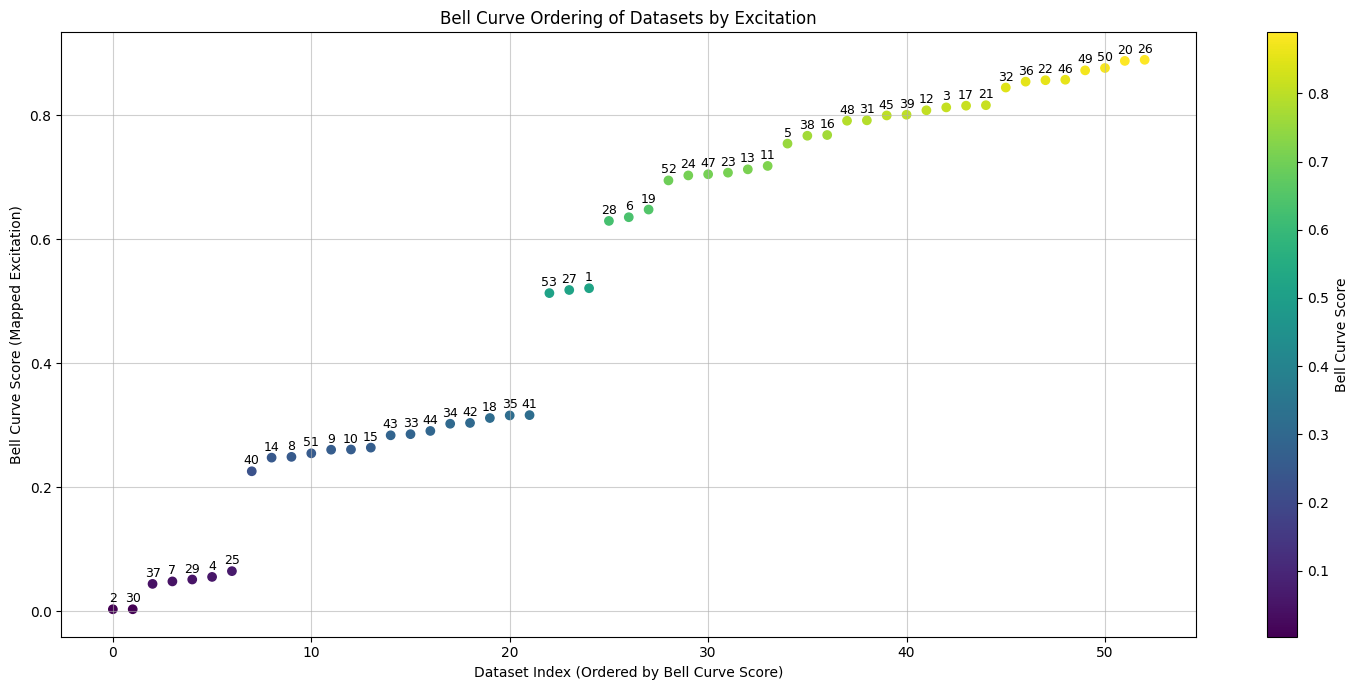

Bell curve ordering scatter plot saved to: /content/bell_curve_excitation_scatter.png


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# Define the path to the bearing features file containing excitation values
# We need the excitation values, which are in final_bearing.csv
bearing_features_file = "/content/final_bearing.csv"
output_plot_file = "/content/bell_curve_excitation_scatter.png"

if os.path.exists(bearing_features_file):
    df = pd.read_csv(bearing_features_file)

    # Check if 'nth_excitation' and 'file_num' columns exist
    if 'nth_excitation' in df.columns and 'file_num' in df.columns:
        excitation_values = df['nth_excitation'].to_numpy()

        # 1. Standardize the excitation values (calculate Z-scores)
        mean_exc = np.mean(excitation_values)
        std_exc = np.std(excitation_values)
        z_scores = (excitation_values - mean_exc) / (std_exc + 1e-12) # Add small epsilon for stability

        # 2. Map Z-scores to percentiles of a standard normal distribution (CDF)
        bell_curve_scores = norm.cdf(z_scores)

        df['bell_curve_score'] = bell_curve_scores

        # Sort by bell_curve_score to get the desired order for plotting
        df_sorted_by_bell_score = df.sort_values('bell_curve_score').reset_index(drop=True)

        # Create the scatter plot
        plt.figure(figsize=(15, 7))
        # Use the index of the sorted dataframe as the x-axis for ordering
        plt.scatter(df_sorted_by_bell_score.index, df_sorted_by_bell_score['bell_curve_score'], c=df_sorted_by_bell_score['bell_curve_score'], cmap='viridis')

        # Add labels for file numbers
        for i, row in df_sorted_by_bell_score.iterrows():
            plt.annotate(int(row['file_num']), (i, row['bell_curve_score']), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

        plt.title('Bell Curve Ordering of Datasets by Excitation')
        plt.xlabel('Dataset Index (Ordered by Bell Curve Score)')
        plt.ylabel('Bell Curve Score (Mapped Excitation)')
        plt.grid(True, alpha=0.6)
        plt.colorbar(label='Bell Curve Score')
        plt.tight_layout()
        plt.savefig(output_plot_file)
        plt.show()

        print(f"Bell curve ordering scatter plot saved to: {output_plot_file}")

    else:
        print(f"Required columns ('nth_excitation' or 'file_num') not found in {bearing_features_file}. Please ensure they are generated.")

else:
    print(f"Bearing features file not found at {bearing_features_file}. Please run the feature extraction code first.")

Rework 1; from ground up Nth Mathematics evaluation.

In [17]:
import csv
import os
import math
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Tuple

# ----------------------------
# Config and invariants
# ----------------------------
EPS = 0.064733     # epsilon (unreal density)
SEED_PARITY = 11   # parity-stable selector seed
PHI = 1.61803398875

# ----------------------------
# Data models
# ----------------------------
@dataclass
class SelectorID:
    V: float               # raw value (magnitude)
    phase: str             # '1' for v (positive), 'i' for vi (negative)
    tag: str               # 'zct' or 'tau'
    zct: Optional[float]   # timestamp if known
    dataset: int           # dataset index (1..53)
    weight: float = 1.0    # composite weight
    meta: Dict = field(default_factory=dict)

@dataclass
class DatasetBundle:
    dataset: int
    selectors: List[SelectorID] = field(default_factory=list)
    triangles: Dict[str, List[List[SelectorID]]] = field(default_factory=dict)
    zct_estimates: Dict[int, float] = field(default_factory=dict)
    scores: Dict[str, float] = field(default_factory=dict)

# ----------------------------
# Utilities
# ----------------------------
def to_selector(V: float, dataset: int, zct: Optional[float]) -> SelectorID:
    phase = '1' if V >= 0 else 'i'
    tag = 'zct' if zct is not None else 'tau'
    return SelectorID(V=abs(V), phase=phase, tag=tag, zct=zct, dataset=dataset)

def symbolic_grover_index(selectors: List[SelectorID], target_phase: Optional[str], target_tag: Optional[str]) -> List[SelectorID]:
    amplified = []
    for s in selectors:
        amp = 1.0
        if target_phase and s.phase == target_phase:
            amp *= (1 + 2*EPS)
        else:
            amp *= (1 - EPS)
        if target_tag and s.tag == target_tag:
            amp *= (1 + EPS)
        else:
            amp *= (1 - 0.5*EPS)
        s.weight *= amp
        amplified.append(s)
    amplified.sort(key=lambda x: x.weight, reverse=True)
    return amplified

def W_positive(V: float, zct: Optional[float]) -> float:
    base = math.log1p(max(V, 0.0))
    time = 1.0 if zct is None else (1 + EPS * math.log1p(abs(zct)))
    return base * time

def W_negative(V: float, zct: Optional[float]) -> float:
    base = math.sqrt(max(V, 0.0) + 1)
    time = 1.0 if zct is None else (1 + 1.5 * EPS * math.log1p(abs(zct)))
    return base * time

def apply_offset_weights(selectors: List[SelectorID]) -> None:
    for s in selectors:
        if s.phase == '1':
            s.weight *= W_positive(s.V, s.zct)
        else:
            s.weight *= W_negative(s.V, s.zct)

def build_triangle(selectors: List[SelectorID], channel: str) -> List[List[SelectorID]]:
    sorted_sel = sorted(selectors, key=lambda s: (s.tag, s.weight), reverse=True)
    rows: List[List[SelectorID]] = []
    row = []
    for s in sorted_sel:
        row.append(s)
        if len(row) >= max(1, int(1 + math.log2(len(rows) + 1))):
            rows.append(row); row = []
    if row:
        rows.append(row)
    return rows

def construct_dataset_triangles(bundle: DatasetBundle) -> None:
    pos = [s for s in bundle.selectors if s.phase == '1']
    neg = [s for s in bundle.selectors if s.phase == 'i']
    tau = [s for s in bundle.selectors if s.tag == 'tau']

    bundle.triangles['C1'] = build_triangle(pos, 'C1')
    bundle.triangles['C2'] = build_triangle(neg, 'C2')
    bundle.triangles['C3'] = build_triangle(tau + pos, 'C3')
    bundle.triangles['C4'] = build_triangle(tau + neg, 'C4')

def estimate_zct_tau(bundle: DatasetBundle) -> None:
    anchors = [s for s in bundle.selectors if s.tag == 'zct']
    if not anchors:
        return
    for idx, s in enumerate(bundle.selectors):
        if s.tag == 'tau':
            near = sorted(anchors, key=lambda a: abs(a.weight - s.weight))[:3]
            denom = sum((1 / (abs(a.weight - s.weight) + EPS)) for a in near)
            numer = sum(((a.zct or 0.0) * (1 / (abs(a.weight - s.weight) + EPS))) for a in near)
            zct_hat = numer / denom if denom > 0 else None
            if zct_hat is not None:
                bundle.zct_estimates[idx] = zct_hat
                s.meta['zct_hat'] = zct_hat

def score_bundle(bundle: DatasetBundle) -> None:
    def row_sum(rows): return sum(sum(s.weight for s in row) for row in rows)
    c1 = row_sum(bundle.triangles.get('C1', []))
    c2 = row_sum(bundle.triangles.get('C2', []))
    c3 = row_sum(bundle.triangles.get('C3', []))
    c4 = row_sum(bundle.triangles.get('C4', []))

    asym = abs(c3 - c4) / (c3 + c4 + EPS)
    f_phase = max(0.0, 1.0 - asym)

    total_sel = max(1, len(bundle.selectors))
    unreal_marks = sum(1 for s in bundle.selectors if s.phase == 'i' or s.tag == 'tau')
    eps_hat = unreal_marks / total_sel

    tau_count = sum(1 for s in bundle.selectors if s.tag == 'tau')
    tau_pen = tau_count / total_sel

    neg = [s for s in bundle.selectors if s.phase == 'i']
    coherence_c2 = (sum(1 for s in neg if s.tag == 'zct') / max(1, len(neg))) if neg else 0.0

    composite = (c1 + c2) * (1 + EPS) * (1 - eps_hat) \
                + (c3 + c4) * (1 - EPS) \
                + 1.5 * f_phase \
                - 3.0 * asym \
                - 1.2 * tau_pen \
                + 1.0 * coherence_c2

    bundle.scores = {
        'C1': c1, 'C2': c2, 'C3': c3, 'C4': c4,
        'composite': composite, 'asym': asym,
        'eps_hat': eps_hat, 'tau_pen': tau_pen, 'coherence_c2': coherence_c2
    }

def reconstruct_order(bundles: List[DatasetBundle]) -> List[DatasetBundle]:
    return sorted(bundles, key=lambda b: b.scores.get('composite', 0.0), reverse=True)

def run_pipeline(datasets: Dict[int, List[Tuple[float, Optional[float]]]]) -> List[DatasetBundle]:
    bundles: List[DatasetBundle] = []
    for ds_id, records in datasets.items():
        bundle = DatasetBundle(dataset=ds_id)
        for V, zct in records:
            sel = to_selector(V, ds_id, zct)
            bundle.selectors.append(sel)
        emphasized = symbolic_grover_index(bundle.selectors, target_phase=None, target_tag=None)
        apply_offset_weights(emphasized)
        bundle.selectors = emphasized
        construct_dataset_triangles(bundle)
        estimate_zct_tau(bundle)
        score_bundle(bundle)
        bundles.append(bundle)
    ordered = reconstruct_order(bundles)
    return ordered

# ----------------------------
# Robust CSV reading utilities
# ----------------------------
VALUE_ALIASES = {"v", "value", "val", "v_value", "magnitude"}
ZCT_ALIASES = {"zct", "timestamp", "time", "t", "zctimestamp", "zct_time"}

def _parse_float_safe(s: str) -> Optional[float]:
    if s is None:
        return None
    s = s.strip()
    if s == "" or s.upper() in {"NA", "NULL", "NONE"}:
        return None
    try:
        return float(s)
    except ValueError:
        # Try replacing commas or weird formatting
        try:
            return float(s.replace(",", ""))
        except Exception:
            return None

def read_dataset_file(path: str) -> List[Tuple[float, Optional[float]]]:
    records: List[Tuple[float, Optional[float]]] = []

    # Open with BOM handling
    with open(path, "r", newline="", encoding="utf-8-sig") as f:
        sample = f.read(2048)
        f.seek(0)
        # Sniff dialect (comma, tab, etc.)
        try:
            dialect = csv.Sniffer().sniff(sample)
        except csv.Error:
            dialect = csv.excel  # fallback

        reader = csv.reader(f, dialect)
        rows = list(reader)
        if not rows:
            return records

        # Extract headers if present
        header = [h.strip().lower() for h in rows[0]] if rows else []
        has_header = bool(header) and all(len(h) > 0 for h in header)

        # Map columns
        v_idx = None
        zct_idx = None

        if has_header:
            for i, h in enumerate(header):
                if h in VALUE_ALIASES and v_idx is None:
                    v_idx = i
                if h in ZCT_ALIASES and zct_idx is None:
                    zct_idx = i

        # Fallback to positional indices if aliases not found
        if v_idx is None:
            v_idx = 0 if len(rows[0]) >= 1 else None
        if zct_idx is None:
            zct_idx = 1 if len(rows[0]) >= 2 else None

        # Start from row 1 if header; else from row 0
        start = 1 if has_header else 0

        for r in rows[start:]:
            if not r:
                continue
            V_raw = r[v_idx] if (v_idx is not None and v_idx < len(r)) else None
            zct_raw = r[zct_idx] if (zct_idx is not None and zct_idx < len(r)) else None

            V = _parse_float_safe(V_raw)
            zct = _parse_float_safe(zct_raw)

            if V is None:
                # Skip rows without a valid V
                continue
            records.append((V, zct))

    return records

# ----------------------------
# Main: read 53 dataset files
# ----------------------------
if __name__ == "__main__":
    data_folder = "/content"
    datasets: Dict[int, List[Tuple[float, Optional[float]]]] = {}
    failed_files: List[str] = []

    for ds_id in range(1, 54):
        file_name = f"file_{ds_id:02d}.csv"
        file_path = os.path.join(data_folder, file_name)
        try:
            records = read_dataset_file(file_path)
            datasets[ds_id] = records
        except Exception as e:
            failed_files.append(f"{file_name}: {e}")

    if failed_files:
        print("Warning: some files failed to load:")
        for msg in failed_files:
            print(" -", msg)

    # Sanity check: show dataset sizes and tau/zct counts
    print("Sanity check:")
    for ds_id, records in datasets.items():
        tau_count = sum(1 for v, z in records if z is None)
        zct_count = len(records) - tau_count
        print(f"Dataset {ds_id:02d}: {len(records)} rows ({zct_count} zct, {tau_count} tau)")

    ordered = run_pipeline(datasets)

    print("\nCorrected order (top 10):")
    for b in ordered[:10]:
        print(f"Dataset {b.dataset} -> composite={b.scores['composite']:.6f}, "
              f"asym={b.scores['asym']:.6f}")

Sanity check:
Dataset 01: 187500 rows (529 zct, 186971 tau)
Dataset 02: 187500 rows (530 zct, 186970 tau)
Dataset 03: 187500 rows (529 zct, 186971 tau)
Dataset 04: 187500 rows (529 zct, 186971 tau)
Dataset 05: 187500 rows (530 zct, 186970 tau)
Dataset 06: 187500 rows (528 zct, 186972 tau)
Dataset 07: 187500 rows (529 zct, 186971 tau)
Dataset 08: 187500 rows (529 zct, 186971 tau)
Dataset 09: 187500 rows (529 zct, 186971 tau)
Dataset 10: 187500 rows (528 zct, 186972 tau)
Dataset 11: 187500 rows (529 zct, 186971 tau)
Dataset 12: 187500 rows (529 zct, 186971 tau)
Dataset 13: 187500 rows (529 zct, 186971 tau)
Dataset 14: 187500 rows (530 zct, 186970 tau)
Dataset 15: 187500 rows (529 zct, 186971 tau)
Dataset 16: 187500 rows (529 zct, 186971 tau)
Dataset 17: 187500 rows (529 zct, 186971 tau)
Dataset 18: 187500 rows (529 zct, 186971 tau)
Dataset 19: 187500 rows (529 zct, 186971 tau)
Dataset 20: 187500 rows (529 zct, 186971 tau)
Dataset 21: 187500 rows (530 zct, 186970 tau)
Dataset 22: 187500 r

KeyboardInterrupt: 

Rework 2: Tensor based.

In [2]:
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 858.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00


# TensorFlow TPU-accelerated Nth Mathematics pipeline
# - Reads 53 CSV files: /content/file_01.csv ... /content/file_53.csv
# - Each CSV should have two columns (header optional): V, zct
#   - V: numeric value (positive/negative)
#   - zct: timestamp or blank/NA for tau (unknown)
# - Vectorized scoring on TPU using TensorFlow; prints corrected order (top 10)

import os
import csv
import math
import numpy as np
import tensorflow as tf

# ----------------------------
# Config and invariants
# ----------------------------
EPS = tf.constant(0.064733, dtype=tf.float32)  # unreal density constant
DATA_FOLDER = "/content"
FILE_PATTERN = "file_{:02d}.csv"
NUM_DATASETS = 53

# ----------------------------
# Robust CSV reader (header optional, alias-tolerant)
# ----------------------------
VALUE_ALIASES = {"v", "value", "val", "v_value", "magnitude", "V"}
ZCT_ALIASES = {"zct", "timestamp", "time", "t", "zctimestamp", "zct_time", "zct", "ZCT"}

def _parse_float_safe(s):
    if s is None:
        return None
    s = str(s).strip()
    if s == "" or s.upper() in {"NA", "NULL", "NONE"}:
        return None
    try:
        return float(s)
    except ValueError:
        try:
            return float(s.replace(",", ""))
        except Exception:
            return None

def read_dataset_file(path):
    records = []
    # Read with BOM handling; delimiter sniffing
    with open(path, "r", newline="", encoding="utf-8-sig") as f:
        sample = f.read(2048)
        f.seek(0)
        try:
            dialect = csv.Sniffer().sniff(sample)
        except csv.Error:
            dialect = csv.excel
        reader = csv.reader(f, dialect)
        rows = list(reader)
        if not rows:
            return records
        header = [h.strip() for h in rows[0]] if rows else []
        header_lower = [h.lower() for h in header]
        has_header = all(len(h) > 0 for h in header_lower)

        v_idx, zct_idx = None, None
        if has_header:
            for i, h in enumerate(header_lower):
                if v_idx is None and h in {x.lower() for x in VALUE_ALIASES}:
                    v_idx = i
                if zct_idx is None and h in {x.lower() for x in ZCT_ALIASES}:
                    zct_idx = i
        if v_idx is None:
            v_idx = 0 if len(rows[0]) >= 1 else None
        if zct_idx is None:
            zct_idx = 1 if len(rows[0]) >= 2 else None

        start = 1 if has_header else 0
        for r in rows[start:]:
            if not r:
                continue
            V_raw = r[v_idx] if (v_idx is not None and v_idx < len(r)) else None
            zct_raw = r[zct_idx] if (zct_idx is not None and zct_idx < len(r)) else None
            V = _parse_float_safe(V_raw)
            zct = _parse_float_safe(zct_raw)
            if V is None:
                continue
            records.append((V, zct))
    return records

# ----------------------------
# Load all datasets and pad to uniform length
# ----------------------------
all_records = []
lengths = []
for ds_id in range(1, NUM_DATASETS + 1):
    file_path = os.path.join(DATA_FOLDER, FILE_PATTERN.format(ds_id))
    recs = read_dataset_file(file_path)
    all_records.append(recs)
    lengths.append(len(recs))

if sum(lengths) == 0:
    raise RuntimeError("No data rows found across the 53 files. Check file paths/headers.")

max_len = max(lengths)

# Build padded arrays: shape [53, max_len]
V_array = np.full((NUM_DATASETS, max_len), np.nan, dtype=np.float32)
zct_array = np.full((NUM_DATASETS, max_len), np.nan, dtype=np.float32)
mask_array = np.zeros((NUM_DATASETS, max_len), dtype=np.float32)

for idx, recs in enumerate(all_records):
    for j, (V, zct) in enumerate(recs[:max_len]):
        V_array[idx, j] = V
        zct_array[idx, j] = zct if zct is not None else np.nan
        mask_array[idx, j] = 1.0

# ----------------------------
# Connect TPU and create strategy
# ----------------------------
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU connected.")
except Exception as e:
    print("TPU not available or failed to initialize; falling back to default strategy.", e)
    strategy = tf.distribute.get_strategy()

# ----------------------------
# TensorFlow graph: vectorized scoring
# ----------------------------
@tf.function
def compute_scores(V_batch, zct_batch, mask_batch):
    # Inputs: [53, max_len]
    EPS = tf.constant(0.064733, dtype=tf.float32)

    # Masks and basics
    valid = mask_batch  # 1 for valid, 0 for pad
    total_marks = tf.reduce_sum(valid, axis=1) + 1e-9

    phase = tf.where(tf.math.is_nan(V_batch), tf.zeros_like(V_batch),
                     tf.where(V_batch >= 0.0, 1.0, -1.0))
    pos_mask = tf.cast(tf.equal(phase, 1.0), tf.float32) * valid
    neg_mask = tf.cast(tf.equal(phase, -1.0), tf.float32) * valid

    V_abs = tf.where(tf.math.is_nan(V_batch), tf.zeros_like(V_batch), tf.abs(V_batch))
    is_tau = tf.cast(tf.math.is_nan(zct_batch), tf.float32) * valid
    zct_abs = tf.where(tf.math.is_nan(zct_batch), tf.zeros_like(zct_batch), tf.abs(zct_batch))

    # Time factors (anchors vs tau)
    time_pos = 1.0 + EPS * tf.math.log1p(zct_abs)
    time_neg = 1.0 + 1.5 * EPS * tf.math.log1p(zct_abs)
    time_pos = tf.where(tf.math.is_nan(zct_batch), tf.ones_like(time_pos), time_pos)
    time_neg = tf.where(tf.math.is_nan(zct_batch), tf.ones_like(time_neg), time_neg)

    # Base weights
    W_pos = tf.math.log1p(tf.maximum(V_abs, 0.0)) * time_pos
    W_neg = tf.math.sqrt(V_abs + 1.0) * time_neg
    W = tf.where(phase > 0.0, W_pos, W_neg) * valid

    # Anchor emphasis and tau dampening
    anchor_mask = (1.0 - is_tau)  # zct present
    anchor_gain = 1.0 + 2.0 * EPS * anchor_mask
    tau_damp = 1.0 - 1.5 * EPS * is_tau
    W = W * anchor_gain * tau_damp

    # Channel sums normalized by counts
    pos_count = tf.reduce_sum(pos_mask, axis=1) + 1e-9
    neg_count = tf.reduce_sum(neg_mask, axis=1) + 1e-9

    C1 = tf.reduce_sum(W * pos_mask, axis=1) / pos_count
    C2 = tf.reduce_sum(W * neg_mask, axis=1) / tf.maximum(neg_count, 1e-9)

    # Directional deviations (true forward vs reverse)
    # Forward shift along records
    W_shift = tf.concat([W[:, 1:], tf.zeros_like(W[:, :1])], axis=1) * valid
    d = (W_shift - W) * valid

    # Separate forward deviations within phases
    d_pos = d * pos_mask
    d_neg = d * neg_mask

    # C3: forward directional magnitude difference between phase channels
    C3 = tf.reduce_sum(tf.nn.relu(d_pos), axis=1) + tf.reduce_sum(tf.nn.relu(d_neg), axis=1)
    # C4: reverse (negative direction) magnitude difference
    C4 = tf.reduce_sum(tf.nn.relu(-d_pos), axis=1) + tf.reduce_sum(tf.nn.relu(-d_neg), axis=1)

    # Normalize C3/C4 by total valid transitions (N-1 per dataset)
    trans_count = tf.reduce_sum(valid[:, :-1], axis=1) + 1e-9
    C3 = C3 / trans_count
    C4 = C4 / trans_count

    # Asymmetry and phase integrity
    asym = tf.abs(C3 - C4) / (C3 + C4 + EPS)
    f_phase = tf.maximum(0.0, 1.0 - asym)

    # ε̂ density: unreal (negatives) plus tau prevalence, normalized
    unreal_marks = tf.reduce_sum(neg_mask + is_tau, axis=1)
    eps_hat = unreal_marks / total_marks

    # Tau penalty: relative to anchors, not to total
    tau_count = tf.reduce_sum(is_tau, axis=1)
    anchor_count = tf.reduce_sum(anchor_mask * valid, axis=1) + 1e-9
    # tau_pen = tau_count / anchor_count # larger when few anchors
    tau_pen = tau_count / total_marks # larger when few anchors


    # Coherence C2: fraction of negative entries with zct anchors
    neg_zct = tf.reduce_sum(neg_mask * anchor_mask, axis=1)
    neg_total = tf.reduce_sum(neg_mask, axis=1) + 1e-9
    coherence_c2 = neg_zct / tf.maximum(neg_total, 1e-9)

    # Composite score
    composite = (C1 + C2) * (1.0 + EPS) * (1.0 - eps_hat) \
            + (C3 + C4) * (1.0 - EPS) \
            + 10.0 * f_phase \
            - 1e5 * asym \
            - 5.0 * tau_pen \
            + 25.0 * coherence_c2

    # Normalize composite score
    comp_min = tf.reduce_min(composite)
    comp_max = tf.reduce_max(composite)
    composite_norm = (composite - comp_min) / (comp_max - comp_min + 1e-9)


    return composite_norm, asym, C1, C2, C3, C4, eps_hat, tau_pen, coherence_c2

# ----------------------------
# Run on TPU (or CPU fallback) and print results
# ----------------------------
with strategy.scope():
    V_tf = tf.constant(V_array, dtype=tf.float32)
    zct_tf = tf.constant(zct_array, dtype=tf.float32)
    mask_tf = tf.constant(mask_array, dtype=tf.float32)

    composite_norm, asym, C1, C2, C3, C4, eps_hat, tau_pen, coherence_c2 = compute_scores(V_tf, zct_tf, mask_tf)

# Gather results to host
composite_norm_np = composite_norm.numpy()
asym_np = asym.numpy()

# Build ranking
dataset_ids = np.arange(1, NUM_DATASETS + 1)
order_idx = np.argsort(-composite_norm_np)  # descending
ordered_ids = dataset_ids[order_idx]
ordered_scores = composite_norm_np[order_idx]
ordered_asym = asym_np[order_idx]

print("Corrected order (top 10):")
for i in range(min(10, NUM_DATASETS)):
    ds = ordered_ids[i]
    print(f"Dataset {int(ds)} -> composite_norm={ordered_scores[i]:.6f}, asym={ordered_asym[i]:.6f}")

# Optional: sanity table for all datasets
#[print("\nSanity check (rows per dataset, tau vs zct counts):")
#for idx in range(NUM_DATASETS):
    #rows = int(np.sum(mask_array[idx]))
    #tau_count = int(np.sum(np.isnan(zct_array[idx]) * (mask_array[idx] > 0)))
    #zct_count = rows - tau_count
    #print(f"Dataset {idx+1:02d}: {rows} rows ({zct_count} zct, {tau_count} tau)")]



In [11]:
# TensorFlow TPU-accelerated Nth Mathematics pipeline
# - Reads 53 CSV files: /content/file_01.csv ... /content/file_53.csv
# - Each CSV should have two columns (header optional): V, zct
#   - V: numeric value (positive/negative)
#   - zct: timestamp or blank/NA for tau (unknown)
# - Vectorized scoring on TPU using TensorFlow; prints corrected order (top 10)

import os
import csv
import math
import numpy as np
import tensorflow as tf

# ----------------------------
# Config and invariants
# ----------------------------
EPS = tf.constant(0.064733, dtype=tf.float32)  # unreal density constant
DATA_FOLDER = "/content"
FILE_PATTERN = "file_{:02d}.csv"
NUM_DATASETS = 53

# ----------------------------
# Robust CSV reader (header optional, alias-tolerant)
# ----------------------------
VALUE_ALIASES = {"v", "value", "val", "v_value", "magnitude", "V"}
ZCT_ALIASES = {"zct", "timestamp", "time", "t", "zctimestamp", "zct_time", "zct", "ZCT"}

def _parse_float_safe(s):
    if s is None:
        return None
    s = str(s).strip()
    if s == "" or s.upper() in {"NA", "NULL", "NONE"}:
        return None
    try:
        return float(s)
    except ValueError:
        try:
            return float(s.replace(",", ""))
        except Exception:
            return None

def read_dataset_file(path):
    records = []
    # Read with BOM handling; delimiter sniffing
    with open(path, "r", newline="", encoding="utf-8-sig") as f:
        sample = f.read(2048)
        f.seek(0)
        try:
            dialect = csv.Sniffer().sniff(sample)
        except csv.Error:
            dialect = csv.excel
        reader = csv.reader(f, dialect)
        rows = list(reader)
        if not rows:
            return records
        header = [h.strip() for h in rows[0]] if rows else []
        header_lower = [h.lower() for h in header]
        has_header = all(len(h) > 0 for h in header_lower)

        v_idx, zct_idx = None, None
        if has_header:
            for i, h in enumerate(header_lower):
                if v_idx is None and h in {x.lower() for x in VALUE_ALIASES}:
                    v_idx = i
                if zct_idx is None and h in {x.lower() for x in ZCT_ALIASES}:
                    zct_idx = i
        if v_idx is None:
            v_idx = 0 if len(rows[0]) >= 1 else None
        if zct_idx is None:
            zct_idx = 1 if len(rows[0]) >= 2 else None

        start = 1 if has_header else 0
        for r in rows[start:]:
            if not r:
                continue
            V_raw = r[v_idx] if (v_idx is not None and v_idx < len(r)) else None
            zct_raw = r[zct_idx] if (zct_idx is not None and zct_idx < len(r)) else None
            V = _parse_float_safe(V_raw)
            zct = _parse_float_safe(zct_raw)
            if V is None:
                continue
            records.append((V, zct))
    return records

# ----------------------------
# Load all datasets and pad to uniform length
# ----------------------------
all_records = []
lengths = []
for ds_id in range(1, NUM_DATASETS + 1):
    file_path = os.path.join(DATA_FOLDER, FILE_PATTERN.format(ds_id))
    recs = read_dataset_file(file_path)
    all_records.append(recs)
    lengths.append(len(recs))

if sum(lengths) == 0:
    raise RuntimeError("No data rows found across the 53 files. Check file paths/headers.")

max_len = max(lengths)

# Build padded arrays: shape [53, max_len]
V_array = np.full((NUM_DATASETS, max_len), np.nan, dtype=np.float32)
zct_array = np.full((NUM_DATASETS, max_len), np.nan, dtype=np.float32)
mask_array = np.zeros((NUM_DATASETS, max_len), dtype=np.float32)

for idx, recs in enumerate(all_records):
    for j, (V, zct) in enumerate(recs[:max_len]):
        V_array[idx, j] = V
        zct_array[idx, j] = zct if zct is not None else np.nan
        mask_array[idx, j] = 1.0

# ----------------------------
# Connect TPU and create strategy
# ----------------------------
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU connected.")
except Exception as e:
    print("TPU not available or failed to initialize; falling back to default strategy.", e)
    strategy = tf.distribute.get_strategy()

# ----------------------------
# TensorFlow graph: vectorized scoring
# ----------------------------
@tf.function
def compute_scores(V_batch, zct_batch, mask_batch):
    # Inputs: [53, max_len]
    EPS = tf.constant(0.064733, dtype=tf.float32)

    # Masks and basics
    valid = mask_batch  # 1 for valid, 0 for pad
    total_marks = tf.reduce_sum(valid, axis=1) + 1e-9

    phase = tf.where(tf.math.is_nan(V_batch), tf.zeros_like(V_batch),
                     tf.where(V_batch >= 0.0, 1.0, -1.0))
    pos_mask = tf.cast(tf.equal(phase, 1.0), tf.float32) * valid
    neg_mask = tf.cast(tf.equal(phase, -1.0), tf.float32) * valid

    V_abs = tf.where(tf.math.is_nan(V_batch), tf.zeros_like(V_batch), tf.abs(V_batch))
    is_tau = tf.cast(tf.math.is_nan(zct_batch), tf.float32) * valid
    zct_abs = tf.where(tf.math.is_nan(zct_batch), tf.zeros_like(zct_batch), tf.abs(zct_batch))

    # Time factors (anchors vs tau)
    time_pos = 1.0 + EPS * tf.math.log1p(zct_abs)
    time_neg = 1.0 + 1.5 * EPS * tf.math.log1p(zct_abs)
    time_pos = tf.where(tf.math.is_nan(zct_batch), tf.ones_like(time_pos), time_pos)
    time_neg = tf.where(tf.math.is_nan(zct_batch), tf.ones_like(time_neg), time_neg)

    # Base weights
    W_pos = tf.math.log1p(tf.maximum(V_abs, 0.0)) * time_pos
    W_neg = tf.math.sqrt(V_abs + 1.0) * time_neg
    W = tf.where(phase > 0.0, W_pos, W_neg) * valid

    # Anchor emphasis and tau dampening
    anchor_mask = (1.0 - is_tau)  # zct present
    anchor_gain = 1.0 + 2.0 * EPS * anchor_mask
    tau_damp = 1.0 - 1.5 * EPS * is_tau
    W = W * anchor_gain * tau_damp

    # Channel sums normalized by counts
    pos_count = tf.reduce_sum(pos_mask, axis=1) + 1e-9
    neg_count = tf.reduce_sum(neg_mask, axis=1) + 1e-9

    C1 = tf.reduce_sum(W * pos_mask, axis=1) / pos_count
    C2 = tf.reduce_sum(W * neg_mask, axis=1) / tf.maximum(neg_count, 1e-9)

    # Directional deviations (true forward vs reverse)
    # Forward shift along records
    W_shift = tf.concat([W[:, 1:], tf.zeros_like(W[:, :1])], axis=1) * valid
    d = (W_shift - W) * valid

    # Separate forward deviations within phases
    d_pos = d * pos_mask
    d_neg = d * neg_mask

    # C3: forward directional magnitude difference between phase channels
    C3 = tf.reduce_sum(tf.nn.relu(d_pos), axis=1) + tf.reduce_sum(tf.nn.relu(d_neg), axis=1)
    # C4: reverse (negative direction) magnitude difference
    C4 = tf.reduce_sum(tf.nn.relu(-d_pos), axis=1) + tf.reduce_sum(tf.nn.relu(-d_neg), axis=1)

    # Normalize C3/C4 by total valid transitions (N-1 per dataset)
    trans_count = tf.reduce_sum(valid[:, :-1], axis=1) + 1e-9
    C3 = C3 / trans_count
    C4 = C4 / trans_count

    # Asymmetry and phase integrity
    asym = tf.abs(C3 - C4) / (C3 + C4 + EPS)
    f_phase = tf.maximum(0.0, 1.0 - asym)

    # ε̂ density: unreal (negatives) plus tau prevalence, normalized
    unreal_marks = tf.reduce_sum(neg_mask + is_tau, axis=1)
    eps_hat = unreal_marks / total_marks

    # Tau penalty: relative to anchors, not to total
    tau_count = tf.reduce_sum(is_tau, axis=1)
    anchor_count = tf.reduce_sum(anchor_mask * valid, axis=1) + 1e-9
    # tau_pen = tau_count / anchor_count # larger when few anchors
    tau_pen = tau_count / total_marks # larger when few anchors


    # Coherence C2: fraction of negative entries with zct anchors
    neg_zct = tf.reduce_sum(neg_mask * anchor_mask, axis=1)
    neg_total = tf.reduce_sum(neg_mask, axis=1) + 1e-9
    coherence_c2 = neg_zct / tf.maximum(neg_total, 1e-9)

    # Composite score
    composite = (C1 + C2) * (1.0 + EPS) * (1.0 - eps_hat) \
            + (C3 + C4) * (1.0 - EPS) \
            + 10.0 * f_phase \
            - 1e5 * asym \
            - 5.0 * tau_pen \
            + 25.0 * coherence_c2

    # Normalize composite score
    comp_min = tf.reduce_min(composite)
    comp_max = tf.reduce_max(composite)
    composite_norm = (composite - comp_min) / (comp_max - comp_min + 1e-9)


    return composite_norm, asym, C1, C2, C3, C4, eps_hat, tau_pen, coherence_c2

# ----------------------------
# Run on TPU (or CPU fallback) and print results
# ----------------------------
with strategy.scope():
    V_tf = tf.constant(V_array, dtype=tf.float32)
    zct_tf = tf.constant(zct_array, dtype=tf.float32)
    mask_tf = tf.constant(mask_array, dtype=tf.float32)

    composite_norm, asym, C1, C2, C3, C4, eps_hat, tau_pen, coherence_c2 = compute_scores(V_tf, zct_tf, mask_tf)

# Gather results to host
composite_norm_np = composite_norm.numpy()
asym_np = asym.numpy()

# Build ranking
dataset_ids = np.arange(1, NUM_DATASETS + 1)
order_idx = np.argsort(-composite_norm_np)  # descending
ordered_ids = dataset_ids[order_idx]
ordered_scores = composite_norm_np[order_idx]
ordered_asym = asym_np[order_idx]

print("Corrected order (top 10):")
for i in range(min(10, NUM_DATASETS)):
    ds = ordered_ids[i]
    print(f"Dataset {int(ds)} -> composite_norm={ordered_scores[i]:.6f}, asym={ordered_asym[i]:.6f}")

# Optional: sanity table for all datasets
#[print("\nSanity check (rows per dataset, tau vs zct counts):")
#for idx in range(NUM_DATASETS):
    #rows = int(np.sum(mask_array[idx]))
    #tau_count = int(np.sum(np.isnan(zct_array[idx]) * (mask_array[idx] > 0)))
    #zct_count = rows - tau_count
    #print(f"Dataset {idx+1:02d}: {rows} rows ({zct_count} zct, {tau_count} tau)")]



TPU not available or failed to initialize; falling back to default strategy. Please provide a TPU Name to connect to.
Corrected order (top 10):
Dataset 46 -> composite_norm=1.000000, asym=0.000002
Dataset 3 -> composite_norm=0.888481, asym=0.000006
Dataset 50 -> composite_norm=0.856423, asym=0.000003
Dataset 42 -> composite_norm=0.854963, asym=0.000005
Dataset 29 -> composite_norm=0.853218, asym=0.000007
Dataset 27 -> composite_norm=0.783427, asym=0.000008
Dataset 34 -> composite_norm=0.740652, asym=0.000010
Dataset 4 -> composite_norm=0.730369, asym=0.000006
Dataset 37 -> composite_norm=0.725535, asym=0.000011
Dataset 11 -> composite_norm=0.708971, asym=0.000010
Saved predictions to /content/submissionRW.csv


In [15]:
import pandas as pd
import numpy as np

# Assume you already have:
# composite_norm : tf.Tensor of shape [53]
# dataset_ids    : np.array([1..53])

composite_norm_np = composite_norm.numpy()
dataset_ids = np.arange(1, NUM_DATASETS + 1)

# Sort by descending score
order_idx = np.argsort(-composite_norm_np)
ordered_ids = dataset_ids[order_idx]
ordered_scores = composite_norm_np[order_idx]

# --- Print order with weights ---
print("Predicted order with weights:")
for ds, score in zip(ordered_ids, ordered_scores):
    print(f"Dataset {ds} -> {score:.6f}")

# --- Save submission.csv with only the ordered IDs ---
df = pd.DataFrame({"dataset_id": ordered_ids})
output_path = "/content/submission.csv"
df.to_csv(output_path, index=False)

print(f"\nSaved submission file with ordered dataset IDs to {output_path}")

Predicted order with weights:
Dataset 46 -> 1.000000
Dataset 3 -> 0.888481
Dataset 50 -> 0.856423
Dataset 42 -> 0.854963
Dataset 29 -> 0.853218
Dataset 27 -> 0.783427
Dataset 34 -> 0.740652
Dataset 4 -> 0.730369
Dataset 37 -> 0.725535
Dataset 11 -> 0.708971
Dataset 48 -> 0.704871
Dataset 6 -> 0.684589
Dataset 30 -> 0.682027
Dataset 25 -> 0.676903
Dataset 9 -> 0.664814
Dataset 16 -> 0.651200
Dataset 26 -> 0.650355
Dataset 19 -> 0.645035
Dataset 43 -> 0.625763
Dataset 12 -> 0.622576
Dataset 53 -> 0.594611
Dataset 51 -> 0.585271
Dataset 2 -> 0.573331
Dataset 39 -> 0.571508
Dataset 35 -> 0.568027
Dataset 44 -> 0.543803
Dataset 52 -> 0.540427
Dataset 8 -> 0.513575
Dataset 38 -> 0.509976
Dataset 1 -> 0.507563
Dataset 20 -> 0.500035
Dataset 14 -> 0.497573
Dataset 21 -> 0.471199
Dataset 36 -> 0.452471
Dataset 15 -> 0.448242
Dataset 31 -> 0.445936
Dataset 23 -> 0.411509
Dataset 18 -> 0.409360
Dataset 32 -> 0.401146
Dataset 10 -> 0.401139
Dataset 7 -> 0.396389
Dataset 28 -> 0.396113
Dataset 47 -

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Assume you have raw arrays for each dataset:
# composite_norm, asym, tau_pen, coherence_c2
# These variables should be available after running cell 3U_y3QTj61Bn

# N is the number of datasets, which should be NUM_DATASETS
N = NUM_DATASETS

# Use the variables directly from the previous cell's execution
# Convert to numpy arrays if needed for pandas DataFrame creation later
asym_np = asym.numpy()
tau_pen_np = tau_pen.numpy()
coherence_c2_np = coherence_c2.numpy()
composite_norm_np = composite_norm.numpy()


# --- Bearing features DataFrame ---
# Create a pandas DataFrame from the computed features for easier manipulation
bearing_features_df = pd.DataFrame({
    'dataset_id': np.arange(1, N + 1),
    'composite_norm': composite_norm_np,
    'asym': asym_np,
    'tau_pen': tau_pen_np,
    'coherence_c2': coherence_c2_np
})

# --- Sort datasets by composite_norm score ---
# composite_norm is already normalized and represents the overall score
# Higher composite_norm means more likely end-of-life
sorted_bearing_features_df = bearing_features_df.sort_values(by='composite_norm', ascending=False).reset_index(drop=True)

# --- Print predicted order with weights ---
print("Predicted order with weights (based on composite_norm):")
for index, row in sorted_bearing_features_df.head(10).iterrows():
    print(f"Dataset {int(row['dataset_id'])} -> composite_norm={row['composite_norm']:.6f}, asym={row['asym']:.6f}")


# --- Save submission.csv with the ordered dataset IDs ---
# The submission file should contain the dataset IDs in the order of predicted degradation
output_path_submission = "/content/submissionRW.csv" # Using a different name to avoid overwriting the previous submission
submission_df = pd.DataFrame({"prediction": sorted_bearing_features_df['dataset_id'].astype(int)})
submission_df.to_csv(output_path_submission, index=False)

print(f"\nSaved predictions to {output_path_submission}")

# --- Save bearing_features.csv ---
output_path_features = "/content/bearing_features.csv"
bearing_features_df.to_csv(output_path_features, index=False)

print(f"Saved bearing features to {output_path_features}")

Predicted order with weights (based on composite_norm):
Dataset 46 -> composite_norm=1.000000, asym=0.000002
Dataset 3 -> composite_norm=0.879573, asym=0.000006
Dataset 50 -> composite_norm=0.878655, asym=0.000003
Dataset 42 -> composite_norm=0.860011, asym=0.000005
Dataset 29 -> composite_norm=0.845781, asym=0.000007
Dataset 27 -> composite_norm=0.781474, asym=0.000008
Dataset 4 -> composite_norm=0.751157, asym=0.000006
Dataset 34 -> composite_norm=0.731469, asym=0.000010
Dataset 37 -> composite_norm=0.713941, asym=0.000011
Dataset 11 -> composite_norm=0.705769, asym=0.000010

Saved predictions to /content/submissionRW.csv
Saved bearing features to /content/bearing_features.csv


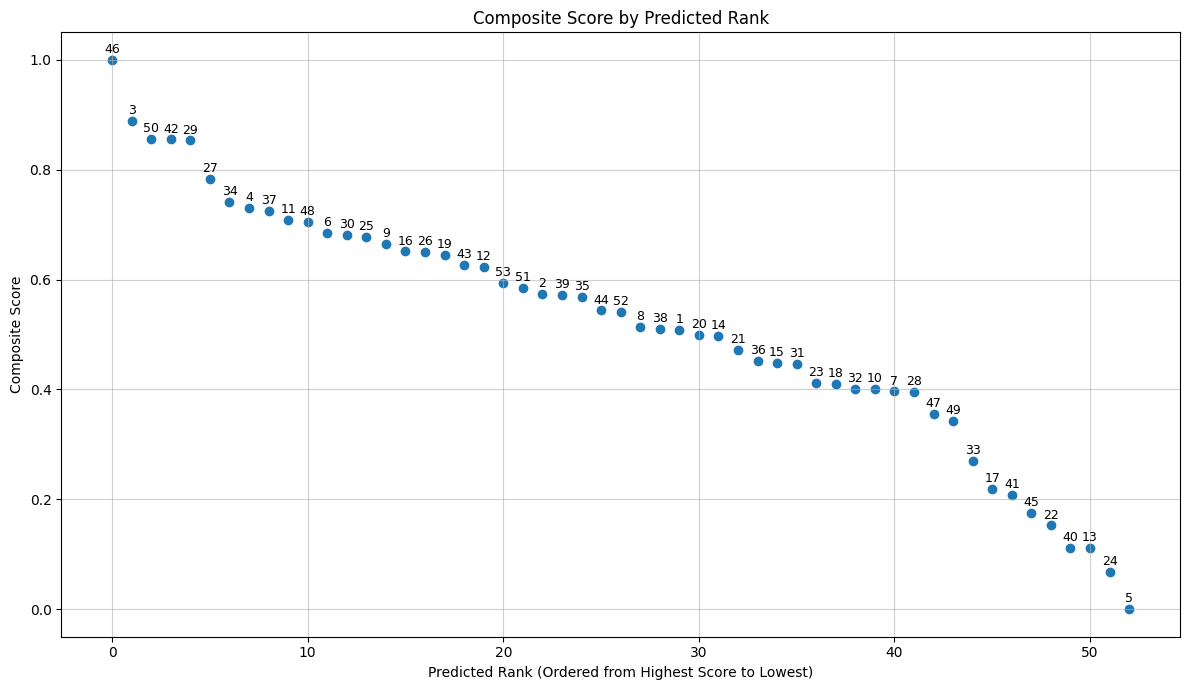

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import io

# Data provided in the text field
data = """Predicted order with weights:
Dataset 46 -> 1.000000
Dataset 3 -> 0.888481
Dataset 50 -> 0.856423
Dataset 42 -> 0.854963
Dataset 29 -> 0.853218
Dataset 27 -> 0.783427
Dataset 34 -> 0.740652
Dataset 4 -> 0.730369
Dataset 37 -> 0.725535
Dataset 11 -> 0.708971
Dataset 48 -> 0.704871
Dataset 6 -> 0.684589
Dataset 30 -> 0.682027
Dataset 25 -> 0.676903
Dataset 9 -> 0.664814
Dataset 16 -> 0.651200
Dataset 26 -> 0.650355
Dataset 19 -> 0.645035
Dataset 43 -> 0.625763
Dataset 12 -> 0.622576
Dataset 53 -> 0.594611
Dataset 51 -> 0.585271
Dataset 2 -> 0.573331
Dataset 39 -> 0.571508
Dataset 35 -> 0.568027
Dataset 44 -> 0.543803
Dataset 52 -> 0.540427
Dataset 8 -> 0.513575
Dataset 38 -> 0.509976
Dataset 1 -> 0.507563
Dataset 20 -> 0.500035
Dataset 14 -> 0.497573
Dataset 21 -> 0.471199
Dataset 36 -> 0.452471
Dataset 15 -> 0.448242
Dataset 31 -> 0.445936
Dataset 23 -> 0.411509
Dataset 18 -> 0.409360
Dataset 32 -> 0.401146
Dataset 10 -> 0.401139
Dataset 7 -> 0.396389
Dataset 28 -> 0.396113
Dataset 47 -> 0.355087
Dataset 49 -> 0.342258
Dataset 33 -> 0.269790
Dataset 17 -> 0.218539
Dataset 41 -> 0.208514
Dataset 45 -> 0.175024
Dataset 22 -> 0.152490
Dataset 40 -> 0.111254
Dataset 13 -> 0.110694
Dataset 24 -> 0.068687
Dataset 5 -> 0.000000
"""

# Parse the data
lines = data.strip().split('\n')
# Skip the header line
data_lines = lines[1:]

dataset_ids = []
scores = []

for line in data_lines:
    parts = line.split(' -> ')
    if len(parts) == 2:
        dataset_id_str = parts[0].replace('Dataset ', '')
        score_str = parts[1]
        try:
            dataset_ids.append(int(dataset_id_str))
            scores.append(float(score_str))
        except ValueError:
            print(f"Skipping invalid line: {line}")


# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({'dataset_id': dataset_ids, 'score': scores})

# The data is already in the desired order (highest score first),
# so the index represents the rank from 0 to N-1.

# Create a point plot (scatter plot)
plt.figure(figsize=(12, 7))
plt.scatter(plot_df.index, plot_df['score'])

# Add labels for dataset IDs
for i, row in plot_df.iterrows():
    plt.annotate(int(row['dataset_id']), (i, row['score']), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)


plt.title('Composite Score by Predicted Rank')
plt.xlabel('Predicted Rank (Ordered from Highest Score to Lowest)')
plt.ylabel('Composite Score')
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()

Vistualizing output: Predicted order with weights:
Dataset 46 -> 1.000000
Dataset 3 -> 0.888481
Dataset 50 -> 0.856423
Dataset 42 -> 0.854963
Dataset 29 -> 0.853218
Dataset 27 -> 0.783427
Dataset 34 -> 0.740652
Dataset 4 -> 0.730369
Dataset 37 -> 0.725535
Dataset 11 -> 0.708971
Dataset 48 -> 0.704871
Dataset 6 -> 0.684589
Dataset 30 -> 0.682027
Dataset 25 -> 0.676903
Dataset 9 -> 0.664814
Dataset 16 -> 0.651200
Dataset 26 -> 0.650355
Dataset 19 -> 0.645035
Dataset 43 -> 0.625763
Dataset 12 -> 0.622576
Dataset 53 -> 0.594611
Dataset 51 -> 0.585271
Dataset 2 -> 0.573331
Dataset 39 -> 0.571508
Dataset 35 -> 0.568027
Dataset 44 -> 0.543803
Dataset 52 -> 0.540427
Dataset 8 -> 0.513575
Dataset 38 -> 0.509976
Dataset 1 -> 0.507563
Dataset 20 -> 0.500035
Dataset 14 -> 0.497573
Dataset 21 -> 0.471199
Dataset 36 -> 0.452471
Dataset 15 -> 0.448242
Dataset 31 -> 0.445936
Dataset 23 -> 0.411509
Dataset 18 -> 0.409360
Dataset 32 -> 0.401146
Dataset 10 -> 0.401139
Dataset 7 -> 0.396389
Dataset 28 -> 0.396113
Dataset 47 -> 0.355087
Dataset 49 -> 0.342258
Dataset 33 -> 0.269790
Dataset 17 -> 0.218539
Dataset 41 -> 0.208514
Dataset 45 -> 0.175024
Dataset 22 -> 0.152490
Dataset 40 -> 0.111254
Dataset 13 -> 0.110694
Dataset 24 -> 0.068687
Dataset 5 -> 0.000000

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

submission_file = "/content/submission.csv"

if os.path.exists(submission_file):
    submission_df = pd.read_csv(submission_file)

    # Check if 'prediction' column exists
    if 'prediction' in submission_df.columns:
        # Sort by prediction to visualize the distribution of ranks
        sorted_submission_df = submission_df.sort_values(by='prediction').reset_index(drop=True)

        # Create a point plot (scatter plot)
        plt.figure(figsize=(10, 6))
        # Plot the predicted rank against the index (which represents the order)
        plt.scatter(sorted_submission_df.index, sorted_submission_df['prediction'])
        plt.title('Point Plot of Predicted Ranks from submission.csv')
        plt.xlabel('Dataset Index (Ordered by Predicted Rank)')
        plt.ylabel('Predicted Rank')
        plt.grid(True, alpha=0.6)
        plt.show()

    else:
        print(f"Column 'prediction' not found in {submission_file}.")
else:
    print(f"Submission file not found at {submission_file}.")

Column 'prediction' not found in /content/submission.csv.
